# Deep Learning Final Project - Pneumonia Classification from Chest X-Rays

**Course:** Deep Learning  
**Assignment:** Final Project  
**Task:** Binary Classification of Chest X-Ray Images

---

### 📋 Project Overview

This project implements and compares two deep learning approaches for classifying chest X-ray images as either **normal** or **pneumonia**:

1. **Convolutional Neural Network (CNN)** - Traditional computer vision approach
2. **Vision Transformer (ViT)** - Transformer-based architecture for image classification

**📊 Dataset**

- **Source:** [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)
- **Structure:** Pre-split into train, validation, and test folders
- **Classes:** Normal vs. Pneumonia
- **Note:** Test set remains untouched until final evaluation

**🎯 Objectives**

1. **Implementation:**
   - Develop a CNN-based classification model
   - Implement a Vision Transformer based on [Dosovitskiy et al. (2020)](https://arxiv.org/pdf/2010.11929)

2. **Evaluation & Analysis:**
   - Quantitative metrics: Accuracy, Precision, Recall, F1-Score
   - Training dynamics: Convergence behavior and generalization
   - Model complexity analysis: Training time, parameter count
   - Overfitting/underfitting assessment
   - Comparative strengths and weaknesses

3. **Enhancement Techniques:**
   - Data augmentation strategies
   - Transfer learning approaches
   - Training optimization techniques

**📚 References**

- [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929)
- [When Vision Transformers Outperform ResNets Without Pre-training or Strong Data Augmentations](https://arxiv.org/pdf/2106.01548)

---

## 📦 Import Dependencies

Essential libraries for deep learning, data processing, and visualization.

In [1]:
# Core PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

# Computer Vision libraries
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

# Data handling and utilities
import kagglehub
import os
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Additional libraries for data analysis
from collections import Counter
from pathlib import Path

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
# Check for MPS (Metal Performance Shaders) on Apple Silicon
if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    print(f"MPS (Metal Performance Shaders) available: {torch.backends.mps.is_available()}")
    device = torch.device("mps")
    print("✅ Using MPS (Apple GPU acceleration)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("⚠️  Using CPU (no GPU acceleration)")

print(f"Selected device: {device}")

PyTorch version: 2.7.0
Torchvision version: 0.22.0
CUDA available: False
MPS (Metal Performance Shaders) available: True
✅ Using MPS (Apple GPU acceleration)
Selected device: mps


## 🔄 Dataset Usage Protocol

**⚠️ Critical Guidelines**

To ensure unbiased evaluation and prevent data leakage, we follow strict data usage protocols:

| Dataset Split | Purpose | Usage Rules |
|---------------|---------|-------------|
| **Training Set** | Model Learning | ✅ Forward pass + backpropagation<br>✅ Weight updates |
| **Validation Set** | Hyperparameter Tuning | ✅ Performance monitoring<br>✅ Early stopping<br>❌ **NO** weight updates |
| **Test Set** | Final Evaluation | ✅ **ONE-TIME** final assessment<br>❌ **NEVER** during training |

**📋 Workflow**

1. Train on training set    → Update model weights
2. Validate on validation   → Monitor performance & tune hyperparameters  
3. Test on test set        → Final unbiased evaluation (once only!)

> **Note:** Using the test set during training leads to **data leakage** and inflated performance metrics.

In [2]:
print("📥 Downloading Chest X-Ray Pneumonia dataset from Kaggle...")

# Download the latest version of the Kaggle dataset to a local directory
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# Set the data directory to the downloaded dataset location
# The dataset structure is: path/chest_xray/train|test|val folders
data_dir = os.path.join(path, "chest_xray")  # Look inside chest_xray folder

print(f"✅ Dataset downloaded successfully!")
print(f"📁 Dataset location: {data_dir}")

# Verify dataset structure
expected_folders = ['train', 'test', 'val']
available_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

print(f"📂 Available folders: {available_folders}")
for folder in expected_folders:
    status = "✅" if folder in available_folders else "❌"
    print(f"   {status} {folder}")

# Check if all expected folders are present
if all(folder in available_folders for folder in expected_folders):
    print("🎉 Dataset structure verified - ready to proceed!")
else:
    print("⚠️  Warning: Some expected folders are missing")
    
# Set individual directory paths for easier access
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val') 
test_dir = os.path.join(data_dir, 'test')

print(f"\n📁 Directory paths:")
print(f"   Training:   {train_dir}")
print(f"   Validation: {val_dir}")
print(f"   Test:       {test_dir}")

📥 Downloading Chest X-Ray Pneumonia dataset from Kaggle...
✅ Dataset downloaded successfully!
📁 Dataset location: /Users/dlevkovitz/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
📂 Available folders: ['test', 'chest_xray', '__MACOSX', 'train', 'val']
   ✅ train
   ✅ test
   ✅ val
🎉 Dataset structure verified - ready to proceed!

📁 Directory paths:
   Training:   /Users/dlevkovitz/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train
   Validation: /Users/dlevkovitz/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val
   Test:       /Users/dlevkovitz/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test


## 📥 Dataset Download & Setup

Downloading the Chest X-Ray Pneumonia dataset from Kaggle and setting up the data directory structure.

In [3]:
# The chest X-ray dataset has the following structure:
# - chest_xray/
#   - train/
#     - NORMAL/
#     - PNEUMONIA/
#   - test/
#     - NORMAL/
#     - PNEUMONIA/
#   - val/
#     - NORMAL/
#     - PNEUMONIA/

# Basic transform for initial data loading (will be enhanced later)
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to standard size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

print("🔄 Creating datasets...")

# Create ImageFolder datasets for each split
if os.path.exists(train_dir):
    train_dataset = ImageFolder(root=train_dir, transform=basic_transform)
    classes_names = train_dataset.classes
    print("✅ TRAINING SET:")
    print(f"   Number of images: {len(train_dataset):,}")
    print(f"   Number of classes: {len(classes_names)}")
    print(f"   Class names: {classes_names}")
    
    # Show class distribution for training set
    train_targets = [train_dataset.targets[i] for i in range(len(train_dataset))]
    train_class_counts = Counter(train_targets)
    for i, class_name in enumerate(classes_names):
        print(f"      {class_name}: {train_class_counts[i]:,} images")
else:
    print(f"❌ Training directory not found at: {train_dir}")

if os.path.exists(val_dir):
    val_dataset = ImageFolder(root=val_dir, transform=basic_transform)
    print(f"\n✅ VALIDATION SET:")
    print(f"   Number of images: {len(val_dataset):,}")
    
    # Show class distribution for validation set
    val_targets = [val_dataset.targets[i] for i in range(len(val_dataset))]
    val_class_counts = Counter(val_targets)
    for i, class_name in enumerate(classes_names):
        print(f"      {class_name}: {val_class_counts[i]:,} images")
else:
    print(f"❌ Validation directory not found at: {val_dir}")

if os.path.exists(test_dir):
    test_dataset = ImageFolder(root=test_dir, transform=basic_transform)
    print(f"\n✅ TEST SET:")
    print(f"   Number of images: {len(test_dataset):,}")
    
    # Show class distribution for test set
    test_targets = [test_dataset.targets[i] for i in range(len(test_dataset))]
    test_class_counts = Counter(test_targets)
    for i, class_name in enumerate(classes_names):
        print(f"      {class_name}: {test_class_counts[i]:,} images")
else:
    print(f"❌ Test directory not found at: {test_dir}")

# Keep the old variable for backward compatibility (pointing to training set)
dataset = train_dataset

print(f"\n🎉 All datasets created successfully!")

🔄 Creating datasets...
✅ TRAINING SET:
   Number of images: 5,216
   Number of classes: 2
   Class names: ['NORMAL', 'PNEUMONIA']
      NORMAL: 1,341 images
      PNEUMONIA: 3,875 images

✅ VALIDATION SET:
   Number of images: 16
      NORMAL: 8 images
      PNEUMONIA: 8 images

✅ TEST SET:
   Number of images: 624
      NORMAL: 234 images
      PNEUMONIA: 390 images

🎉 All datasets created successfully!


In [4]:
# Configuration
BATCH_SIZE = 32

print("🔄 Setting up data loaders...")

# Create data loaders for efficient batch processing
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,          # Shuffle for better training
    num_workers=2,         # Parallel data loading
    pin_memory=True        # Faster GPU transfer
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,         # No shuffle for consistent validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,         # No shuffle for consistent testing
    num_workers=2,
    pin_memory=True
)

# Display data loader statistics
print("📊 Data Loader Summary:")
print(f"   Training batches:   {len(train_loader):,}")
print(f"   Validation batches: {len(val_loader):,}")
print(f"   Test batches:       {len(test_loader):,}")
print(f"   Batch size:         {BATCH_SIZE}")

# Calculate total samples
total_train = len(train_dataset)
total_val = len(val_dataset)
total_test = len(test_dataset)
total_samples = total_train + total_val + total_test

print(f"\n📈 Dataset Distribution:")
print(f"   Training samples:   {total_train:,} ({total_train/total_samples*100:.1f}%)")
print(f"   Validation samples: {total_val:,} ({total_val/total_samples*100:.1f}%)")
print(f"   Test samples:       {total_test:,} ({total_test/total_samples*100:.1f}%)")
print(f"   Total samples:      {total_samples:,}")

print("\n✅ Data loaders configured successfully!")

🔄 Setting up data loaders...
📊 Data Loader Summary:
   Training batches:   163
   Validation batches: 1
   Test batches:       20
   Batch size:         32

📈 Dataset Distribution:
   Training samples:   5,216 (89.1%)
   Validation samples: 16 (0.3%)
   Test samples:       624 (10.7%)
   Total samples:      5,856

✅ Data loaders configured successfully!


## 👁️ Exploratory Data Analysis

### 📊 Dataset Visualization

Visual exploration of the dataset to understand the characteristics of normal vs. pneumonia chest X-rays.

🎨 Creating dataset visualization...
🔍 Collecting sample images...


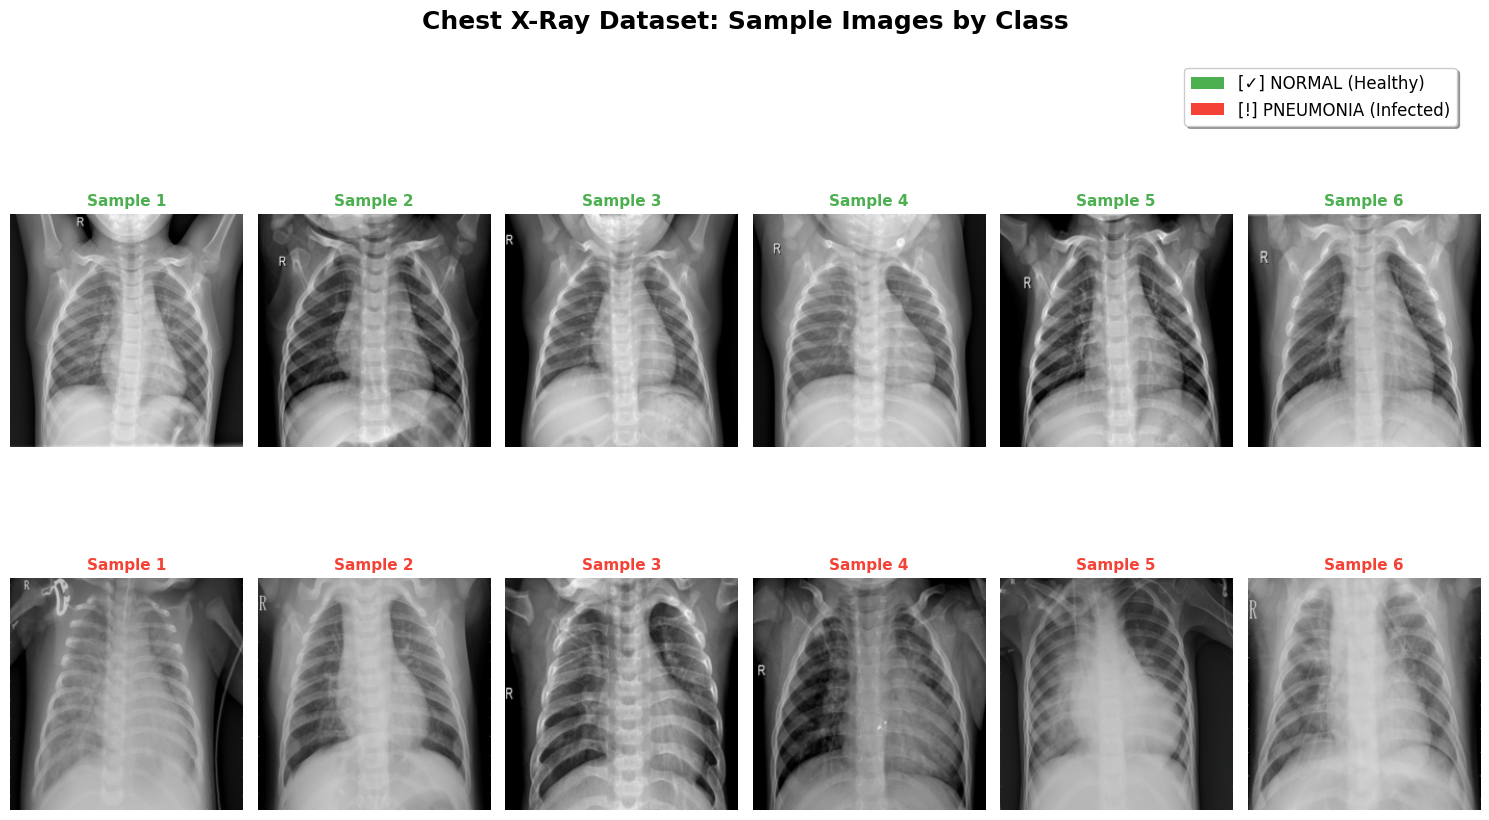

✅ Displayed 6 samples per class
🎨 Color coding: Green = Normal, Red = Pneumonia


In [5]:
def visualize_dataset_samples(dataset, class_names, samples_per_class=6, figsize=(15, 10)):
    """
    Display sample images from each class in a grid layout with clear class labels.
    
    Args:
        dataset: PyTorch dataset
        class_names: List of class names
        samples_per_class: Number of samples to show per class
        figsize: Figure size
    """
    
    def unnormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        """
        Unnormalize an image tensor that was normalized with ImageNet stats.
        """
        mean = torch.tensor(mean).view(3, 1, 1)
        std = torch.tensor(std).view(3, 1, 1)
        return tensor * std + mean
    
    # Find samples for each class
    class_samples = {i: [] for i in range(len(class_names))}
    
    print("🔍 Collecting sample images...")
    for image, label in dataset:
        if len(class_samples[label]) < samples_per_class:
            class_samples[label].append(image)
        
        # Stop when we have enough samples for all classes
        if all(len(samples) >= samples_per_class for samples in class_samples.values()):
            break
    
    # Create visualization grid
    rows = len(class_names)
    cols = samples_per_class
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Enhanced main title
    fig.suptitle('Chest X-Ray Dataset: Sample Images by Class', 
                 fontsize=18, fontweight='bold', y=0.95)
    
    # Define colors for each class for better visual distinction
    class_colors = {
        'NORMAL': '#4CAF50',      # Green for normal
        'PNEUMONIA': '#F44336'    # Red for pneumonia
    }
    
    for class_idx, class_name in enumerate(class_names):
        # Add a prominent class header for each row
        class_color = class_colors.get(class_name, '#2196F3')  # Default blue
        
        for sample_idx in range(min(samples_per_class, len(class_samples[class_idx]))):
            row = class_idx
            col = sample_idx
            
            # Handle both single row and multiple rows
            ax = axes[row, col] if rows > 1 else axes[col]
            
            # Display image
            image = class_samples[class_idx][sample_idx]
            
            # Unnormalize the image for proper display
            if image.shape[0] == 3:  # RGB image
                image_display = unnormalize_image(image)
                # Clamp values to [0, 1] range for safety
                image_display = torch.clamp(image_display, 0, 1)
                ax.imshow(image_display.permute(1, 2, 0))
            elif image.shape[0] == 1:  # Grayscale
                # For grayscale, we still need to handle normalization
                image_display = image.squeeze()
                # If the image was normalized, unnormalize it (assuming single channel normalization)
                image_display = (image_display * 0.229) + 0.485  # Single channel ImageNet normalization
                image_display = torch.clamp(image_display, 0, 1)
                ax.imshow(image_display, cmap='gray')
            else:
                # Fallback: just clamp the values
                if image.shape[0] == 1:
                    ax.imshow(torch.clamp(image.squeeze(), 0, 1), cmap='gray')
                else:
                    ax.imshow(torch.clamp(image.permute(1, 2, 0), 0, 1))
            
            # Enhanced labeling and formatting
            if sample_idx == 0:
                # Add prominent row label with class name and icon
                if class_name == 'NORMAL':
                    label_text = f'[✓] {class_name}\n(Healthy Lungs)'
                elif class_name == 'PNEUMONIA':
                    label_text = f'[!] {class_name}\n(Infected Lungs)'
                else:
                    label_text = f'{class_name}'
                    
                ax.set_ylabel(label_text, fontsize=14, fontweight='bold', 
                             color=class_color, rotation=0, ha='right', va='center')
            
            # Add sample number with class-specific styling
            ax.set_title(f'Sample {sample_idx + 1}', fontsize=11, 
                        color=class_color, fontweight='bold')
            ax.axis('off')
            
            # Add colored border around each image for class distinction
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color(class_color)
                spine.set_linewidth(3)
    
    # Add legend to explain the colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=class_colors['NORMAL'], label='[✓] NORMAL (Healthy)'),
        Patch(facecolor=class_colors['PNEUMONIA'], label='[!] PNEUMONIA (Infected)')
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.9), 
               fontsize=12, frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Make room for the legend and title
    plt.show()
    
    print(f"✅ Displayed {samples_per_class} samples per class")
    print(f"🎨 Color coding: Green = Normal, Red = Pneumonia")

# Execute visualization
print("🎨 Creating dataset visualization...")
class_names = ['NORMAL', 'PNEUMONIA']
visualize_dataset_samples(train_dataset, class_names)

### 📊 Analyze Distrubution

In [6]:
def analyze_dataset_distribution(dataset, class_names):
    """
    Analyze and display comprehensive dataset statistics.
    """
    print("📊 Dataset Distribution Analysis")
    print("=" * 50)
    
    # Calculate class distribution
    class_counts = {name: 0 for name in class_names}
    
    for _, label in dataset:
        class_name = class_names[label]
        class_counts[class_name] += 1
    
    total_samples = sum(class_counts.values())
    
    # Display distribution table
    print(f"\n{'Class':<12} {'Count':<8} {'Percentage':<12} {'Bar Chart'}")
    print("-" * 50)
    
    max_count = max(class_counts.values())
    for class_name, count in class_counts.items():
        percentage = (count / total_samples) * 100
        bar_length = int((count / max_count) * 30)  # Normalize to 30 chars
        bar = "█" * bar_length
        print(f"{class_name:<12} {count:<8} {percentage:>6.1f}%      {bar}")
    
    # Class balance analysis
    print(f"\n📈 Balance Analysis:")
    max_class = max(class_counts.items(), key=lambda x: x[1])
    min_class = min(class_counts.items(), key=lambda x: x[1])
    imbalance_ratio = max_class[1] / min_class[1]
    
    print(f"   • Most frequent:  {max_class[0]} ({max_class[1]:,} images)")
    print(f"   • Least frequent: {min_class[0]} ({min_class[1]:,} images)")
    print(f"   • Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    # Recommendations based on imbalance
    if imbalance_ratio > 2.0:
        print(f"   ⚠️  High class imbalance detected!")
        print(f"      Consider using weighted loss or data augmentation")
    elif imbalance_ratio > 1.5:
        print(f"   ⚡ Moderate class imbalance")
        print(f"      Monitor model performance on minority class")
    else:
        print(f"   ✅ Well-balanced dataset")
    
    print(f"\n🔢 Total samples: {total_samples:,}")
    return class_counts

# Analyze the training dataset
train_distribution = analyze_dataset_distribution(train_dataset, class_names)

📊 Dataset Distribution Analysis

Class        Count    Percentage   Bar Chart
--------------------------------------------------
NORMAL       1341       25.7%      ██████████
PNEUMONIA    3875       74.3%      ██████████████████████████████

📈 Balance Analysis:
   • Most frequent:  PNEUMONIA (3,875 images)
   • Least frequent: NORMAL (1,341 images)
   • Imbalance ratio: 2.89:1
   ⚠️  High class imbalance detected!
      Consider using weighted loss or data augmentation

🔢 Total samples: 5,216


#### 📊 Test Set Distribution Analysis

In [7]:
test_distribution = analyze_dataset_distribution(test_dataset, class_names)

📊 Dataset Distribution Analysis

Class        Count    Percentage   Bar Chart
--------------------------------------------------
NORMAL       234        37.5%      ██████████████████
PNEUMONIA    390        62.5%      ██████████████████████████████

📈 Balance Analysis:
   • Most frequent:  PNEUMONIA (390 images)
   • Least frequent: NORMAL (234 images)
   • Imbalance ratio: 1.67:1
   ⚡ Moderate class imbalance
      Monitor model performance on minority class

🔢 Total samples: 624


## ⚙️ Configuration & Training Parameters

Central configuration for all hyperparameters and training settings. This ensures reproducible experiments and easy parameter tuning.

In [ ]:
# ⚙️ CONFIGURATION PARAMETERS
# =================================

# Data configuration
val_split = 0.2               # Validation split ratio if creating from train
img_size = 224                # Input image size (224x224)
batch_size = 32               # Batch size for training
num_workers = 4               # DataLoader workers

# Training configuration
base_epochs = 20              # Epochs for final training after architecture search
lr = 3e-4                     # Learning rate
weight_decay = 1e-4           # Weight decay for regularization
patience = 5                  # Early stopping patience
seed = 42                     # Random seed for reproducibility
recall_tolerance = 0.05         # Allowable drop in pneumonia recall for F1 improvement
selection_method = "weighted_f1" # Method to select best architecture based on weighted F1 score

# Advanced settings
use_amp = True                # Automatic Mixed Precision (CUDA only)
deterministic = True          # Deterministic operations for reproducibility
class_weighting = True        # Use class weights for imbalanced data
eval_test_once_only = True    # Enforce single test evaluation

# Architecture search settings
search_trials = 15            # Number of random architecture configurations to try
search_max_epochs = 12        # Max epochs per trial during architecture search
patience_search = 3           # Early stopping patience for architecture search (shorter)
fast_mode = False             # Quick smoke test mode (fewer trials/epochs)

# Cross-Validation settings
use_cv_search = True          # Enable K-Fold CV for architecture search (more robust but slower)
cv_folds = 3                  # Number of CV folds (3 is good balance of robustness vs speed)
cv_max_epochs = 8             # Reduced epochs per fold for efficiency
cv_patience = 2               # Shorter patience for CV folds

# Check if need to delete
# Override for fast testing
if fast_mode:
    print("🚀 FAST MODE ENABLED - Reducing trials and epochs for quick testing")
    search_trials = 3
    base_epochs = 5
    search_max_epochs = 3
    cv_max_epochs = 3
    cv_folds = 2

# Set seeds for reproducibility
if deterministic:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"🔒 Deterministic mode enabled with seed {seed}")

# Device configuration with preference: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"🚀 Using CUDA: {torch.cuda.get_device_name(0)}")
    if use_amp:
        print("⚡ Automatic Mixed Precision enabled")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")
    use_amp = False  # AMP not supported on MPS
    print("🍎 Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    use_amp = False  # AMP only for CUDA
    print("💻 Using CPU (consider using GPU for faster training)")

# Configuration summary
print(f"\n📋 Configuration Summary:")
print(f"   • Image size: {img_size}x{img_size}")
print(f"   • Batch size: {batch_size}")
print(f"   • Learning rate: {lr}")
print(f"   • Search trials: {search_trials}")
print(f"   • Max epochs per trial: {search_max_epochs}")
print(f"   • Final training epochs: {base_epochs}")
print(f"   • Early stopping patience (search): {patience_search}")
print(f"   • Early stopping patience (final): {patience}")
print(f"   • Device: {device}")
print(f"   • Mixed precision: {use_amp}")
print(f"   • Class weighting: {class_weighting}")
print(f"   • Deterministic: {deterministic}")

# NEW: CV Configuration Summary
if use_cv_search:
    print(f"\n🔄 Cross-Validation Settings:")
    print(f"   • CV enabled: {use_cv_search}")
    print(f"   • CV folds: {cv_folds}")
    print(f"   • CV epochs per fold: {cv_max_epochs}")
    print(f"   • CV patience: {cv_patience}")
    print(f"   • Estimated CV time per trial: ~{cv_folds * cv_max_epochs * 0.5:.1f} minutes")
else:
    print(f"\n🔄 Using standard single validation split for architecture search")

# Global flag to ensure test set is only evaluated once
_test_evaluated = False

🔒 Deterministic mode enabled with seed 42
🍎 Using MPS (Apple Silicon GPU)

📋 Configuration Summary:
   • Image size: 224x224
   • Batch size: 32
   • Learning rate: 0.0003
   • Search trials: 15
   • Max epochs per trial: 12
   • Final training epochs: 20
   • Early stopping patience (search): 3
   • Early stopping patience (final): 5
   • Device: mps
   • Mixed precision: False
   • Class weighting: True
   • Deterministic: True

🔄 Cross-Validation Settings:
   • CV enabled: True
   • CV folds: 3
   • CV epochs per fold: 8
   • CV patience: 2
   • Estimated CV time per trial: ~12.0 minutes


## 🔄 Enhanced Data Loading & Transforms

Implementing proper data transforms for training/validation and handling validation split configuration.

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

use_existing_val = False       # Use provided validation split or create from train

# Define transforms for training and validation/test
print("🔄 Setting up enhanced data transforms...")

# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] for single channel
])

# Validation/Test transforms (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("✅ Transforms configured:")
print(f"   • Training: Resize, RandomFlip, RandomRotation(10°), RandomCrop, Normalize")
print(f"   • Val/Test: Resize, CenterCrop, Normalize")

# Load datasets with proper transforms
print(f"\n📂 Loading datasets with enhanced transforms...")

# Training dataset with augmentation
final_train_dataset = ImageFolder(root=train_dir, transform=train_transforms)

# Check if we should use existing validation split or create new one
if use_existing_val and os.path.exists(val_dir):
    print(f"✅ Using existing validation split from {val_dir}")
    final_val_dataset = ImageFolder(root=val_dir, transform=val_test_transforms)
else:
    print(f"🔀 Creating stratified validation split ({val_split:.1%}) from training data")
    
    # Create stratified split from training data
    full_train_dataset = ImageFolder(root=train_dir, transform=val_test_transforms)
    
    # Get labels for stratified split
    train_labels = [full_train_dataset.targets[i] for i in range(len(full_train_dataset))]
    
    # Create stratified split
    train_indices, val_indices = train_test_split(
        range(len(full_train_dataset)),
        test_size=val_split,
        stratify=train_labels,
        random_state=seed
    )
    
    # Create subset datasets
    final_train_dataset = Subset(
        ImageFolder(root=train_dir, transform=train_transforms), 
        train_indices
    )
    final_val_dataset = Subset(
        ImageFolder(root=train_dir, transform=val_test_transforms), 
        val_indices
    )
    
    print(f"   • Training samples: {len(train_indices):,}")
    print(f"   • Validation samples: {len(val_indices):,}")

# Test dataset (always use test directory)
final_test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms)

print(f"\n📊 Final dataset sizes:")
print(f"   • Training: {len(final_train_dataset):,}")
print(f"   • Validation: {len(final_val_dataset):,}")
print(f"   • Test: {len(final_test_dataset):,}")

# Create data loaders
final_train_loader = DataLoader(
    final_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=(device.type == 'cuda'),
    drop_last=True  # Ensure consistent batch sizes
)

final_val_loader = DataLoader(
    final_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=(device.type == 'cuda')
)

final_test_loader = DataLoader(
    final_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=(device.type == 'cuda')
)

# Compute class weights for handling imbalanced data
if class_weighting:
    print(f"\n⚖️  Computing class weights for imbalanced data...")
    
    # Get training labels
    if isinstance(final_train_dataset, Subset):
        # If using subset, get labels from the underlying dataset
        base_dataset = final_train_dataset.dataset
        train_labels = [base_dataset.targets[i] for i in final_train_dataset.indices]
    else:
        train_labels = final_train_dataset.targets
    
    class_counts = Counter(train_labels)
    total_samples = len(train_labels)
    num_classes = len(class_counts)
    
    # Calculate inverse frequency weights
    class_weights = []
    for i in range(num_classes):
        weight = total_samples / (num_classes * class_counts[i])
        class_weights.append(weight)
    
    class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
    
    print(f"   • Class weights: {[f'{w:.3f}' for w in class_weights]}")
    for i, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        print(f"     - {class_name}: {class_weights[i]:.3f}")
else:
    class_weights = None
    print(f"⚖️  Class weighting disabled")

print(f"\n✅ Enhanced data loading complete!")
print(f"   • Training batches: {len(final_train_loader)}")
print(f"   • Validation batches: {len(final_val_loader)}")
print(f"   • Test batches: {len(final_test_loader)}")

🔄 Setting up enhanced data transforms...
✅ Transforms configured:
   • Training: Resize, RandomFlip, RandomRotation(10°), RandomCrop, Normalize
   • Val/Test: Resize, CenterCrop, Normalize

📂 Loading datasets with enhanced transforms...
🔀 Creating stratified validation split (20.0%) from training data
   • Training samples: 4,172
   • Validation samples: 1,044

📊 Final dataset sizes:
   • Training: 4,172
   • Validation: 1,044
   • Test: 624

⚖️  Computing class weights for imbalanced data...
   • Class weights: ['1.944', '0.673']
     - NORMAL: 1.944
     - PNEUMONIA: 0.673

✅ Enhanced data loading complete!
   • Training batches: 130
   • Validation batches: 33
   • Test batches: 20


## 📊 Metrics & Evaluation Utilities

Comprehensive evaluation functions including accuracy, precision, recall, F1-score, confusion matrices, and classification reports.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
from datetime import datetime

def compute_metrics(y_true, y_pred, class_names=None):
    """
    Compute comprehensive classification metrics.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: List of class names
    
    Returns:
        Dictionary with all computed metrics
    """
    if class_names is None:
        class_names = ['NORMAL', 'PNEUMONIA']
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted')
    }
    
    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    for i, class_name in enumerate(class_names):
        metrics[f'precision_{class_name.lower()}'] = precision_per_class[i]
        metrics[f'recall_{class_name.lower()}'] = recall_per_class[i]
        metrics[f'f1_{class_name.lower()}'] = f1_per_class[i]
    
    return metrics

def plot_confusion_matrix(y_true, y_pred, class_names=None, figsize=(10, 8), title_prefix=""):
    """
    Plot an enhanced confusion matrix heatmap with clinical interpretation annotations.
    Returns (cm_raw, cm_norm) for downstream use.
    """
    if class_names is None:
        class_names = ['NORMAL', 'PNEUMONIA']

    # Compute confusion matrices
    cm_raw = confusion_matrix(y_true, y_pred)
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

    # Enhanced single heatmap (raw counts) with clinical annotations
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm_raw,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Count'},
    )

    plt.title(f"{title_prefix}Enhanced Confusion Matrix", fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    # Add clinical interpretation annotations for binary case
    if cm_raw.shape == (2, 2):
        tn, fp, fn, tp = cm_raw.ravel()
        ax = plt.gca()
        ax.text(0.5, -0.15, f"TN: {tn} (Correct Normal)", ha='center', transform=ax.transAxes)
        ax.text(1.5, -0.15, f"FP: {fp} (False Pneumonia)", ha='center', transform=ax.transAxes)
        ax.text(0.5, -0.25, f"FN: {fn} (Missed Pneumonia)", ha='center', transform=ax.transAxes)
        ax.text(1.5, -0.25, f"TP: {tp} (Correct Pneumonia)", ha='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

    return cm_raw, cm_norm

def classification_report_to_df(y_true, y_pred, class_names=None):
    """
    Convert sklearn classification report to a pandas DataFrame.
    """
    if class_names is None:
        class_names = ['NORMAL', 'PNEUMONIA']
    
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    
    return df

def print_metrics_summary(metrics, title="Model Performance"):
    """
    Print a nicely formatted metrics summary.
    """
    print(f"\n{'='*50}")
    print(f"📊 {title}")
    print(f"{'='*50}")
    
    # Overall metrics
    print(f"🎯 Overall Performance:")
    print(f"   • Accuracy:        {metrics['accuracy']:.4f}")
    print(f"   • Precision (macro): {metrics['precision_macro']:.4f}")
    print(f"   • Recall (macro):    {metrics['recall_macro']:.4f}")
    print(f"   • F1-Score (macro):  {metrics['f1_macro']:.4f}")
    
    print(f"\n🏷️  Per-Class Performance:")
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_key = class_name.lower()
        print(f"   {class_name}:")
        print(f"     - Precision: {metrics[f'precision_{class_key}']:.4f}")
        print(f"     - Recall:    {metrics[f'recall_{class_key}']:.4f}")
        print(f"     - F1-Score:  {metrics[f'f1_{class_key}']:.4f}")
    
    print(f"\n⚖️  Weighted Averages:")
    print(f"   • Precision: {metrics['precision_weighted']:.4f}")
    print(f"   • Recall:    {metrics['recall_weighted']:.4f}")
    print(f"   • F1-Score:  {metrics['f1_weighted']:.4f}")


def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    """
    Plot ROC curve for binary classification with AUC score.
    
    Args:
        y_true: True binary labels (0 or 1)
        y_scores: Prediction scores/probabilities for the positive class (Pneumonia)
        title: Title for the plot
    """
    from sklearn.metrics import roc_curve, auc
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line for random classifier
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier (AUC = 0.500)')
    
    # Formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(f'{title} - Medical Imaging Performance')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Add AUC interpretation text
    if roc_auc >= 0.9:
        interpretation = "Excellent"
        color = "green"
    elif roc_auc >= 0.8:
        interpretation = "Good"
        color = "orange"
    elif roc_auc >= 0.7:
        interpretation = "Fair"
        color = "orange"
    else:
        interpretation = "Poor"
        color = "red"
    
    plt.text(0.6, 0.2, f'AUC = {roc_auc:.3f}\n({interpretation})', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed interpretation
    print(f"🎯 ROC-AUC Analysis:")
    print(f"   • AUC Score: {roc_auc:.4f}")
    print(f"   • Interpretation: {interpretation}")
    print(f"   • Clinical Context:")
    
    if roc_auc >= 0.9:
        print(f"     → Excellent discriminatory ability")
        print(f"     → Model can effectively distinguish pneumonia from normal cases")
    elif roc_auc >= 0.8:
        print(f"     → Good discriminatory ability")
        print(f"     → Model performs well for clinical screening")
    elif roc_auc >= 0.7:
        print(f"     → Fair discriminatory ability")
        print(f"     → May require additional clinical evaluation")
    else:
        print(f"     → Poor discriminatory ability")
        print(f"     → Not suitable for clinical use without significant improvement")
    
    return roc_auc

def plot_precision_recall_curve(y_true, y_scores, title='Precision-Recall Curve'):
    """
    Plot Precision-Recall curve for binary classification with Average Precision (AP) score.
    
    Args:
        y_true: True binary labels (0 or 1)
        y_scores: Prediction scores/probabilities for the positive class (Pneumonia)
        title: Title for the plot
    """
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap_score = average_precision_score(y_true, y_scores)
    
    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, color='darkgreen', where='post', lw=2,
             label=f'PR curve (AP = {ap_score:.3f})')
    
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='green')
    
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title)
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"🎯 Precision-Recall Analysis:")
    print(f"   • Average Precision (AP) Score: {ap_score:.4f}")
    
    return ap_score

def evaluate_model(model, data_loader, device, class_names=None):
    """
    Evaluate model on a dataset and return predictions, scores, and metrics.
    Now returns raw prediction scores for ROC curve analysis.
    """
    
    model.eval()
    all_preds = []
    all_labels = []
    all_scores = []  # New: Store raw prediction scores for positive class
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # Get predictions (class indices)
            _, predicted = torch.max(outputs, 1)
            
            # Get prediction scores for the positive class (Pneumonia = class 1)
            scores = F.softmax(outputs, dim=1)[:, 1]  # Probability for pneumonia class
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(scores.cpu().numpy())  # Store scores for ROC curve
    
    # Compute metrics
    metrics = compute_metrics(all_labels, all_preds, class_names)
    
    return all_labels, all_preds, all_scores, metrics

print("✅ Metrics utilities loaded:")
print("   • compute_metrics() - Calculate accuracy, precision, recall, F1")
print("   • plot_confusion_matrix() - Visualize confusion matrices")
print("   • classification_report_to_df() - Convert sklearn report to DataFrame")
print("   • print_metrics_summary() - Formatted metrics display")
print("   • evaluate_model() - Complete model evaluation pipeline")

✅ Metrics utilities loaded:
   • compute_metrics() - Calculate accuracy, precision, recall, F1
   • plot_confusion_matrix() - Visualize confusion matrices
   • classification_report_to_df() - Convert sklearn report to DataFrame
   • print_metrics_summary() - Formatted metrics display
   • evaluate_model() - Complete model evaluation pipeline


## 🏗️ Flexible CNN Architecture

Configurable CNN architecture that can vary depth, width, kernels, normalization, pooling, activation, and dropout.

In [11]:
class FlexibleCNN(nn.Module):
    """
    Flexible CNN architecture that can be configured with various parameters.
    
    Architecture components:
    - Configurable number of convolutional blocks
    - Various activation functions (ReLU, LeakyReLU, GELU)
    - Optional batch normalization
    - Different pooling types (MaxPool, AvgPool)
    - Configurable dropout
    - Flexible classifier head
    """
    
    def __init__(self, 
                 num_classes=2,
                 input_channels=3,
                 depth=4,                    # Number of conv blocks
                 base_channels=32,           # Starting number of channels
                 channel_multiplier=2,       # Channel growth factor
                 kernel_size=3,              # Convolution kernel size
                 activation='relu',          # Activation function
                 use_bn=True,                # Batch normalization
                 pool_type='max',            # Pooling type
                 dropout=0.2,                # Dropout probability
                 global_pool='avg',          # Global pooling type
                 classifier_hidden=None):    # Hidden layer in classifier
        
        super(FlexibleCNN, self).__init__()
        
        self.config = {
            'num_classes': num_classes,
            'input_channels': input_channels,
            'depth': depth,
            'base_channels': base_channels,
            'channel_multiplier': channel_multiplier,
            'kernel_size': kernel_size,
            'activation': activation,
            'use_bn': use_bn,
            'pool_type': pool_type,
            'dropout': dropout,
            'global_pool': global_pool,
            'classifier_hidden': classifier_hidden
        }
        
        # Activation function
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1, inplace=True)
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'swish':
            self.activation = nn.SiLU()  # SiLU is the same as Swish activation
        else:
            raise ValueError(f"Unsupported activation: {activation}")
        
        # Pooling function
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(2, 2)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(2, 2)
        else:
            raise ValueError(f"Unsupported pool type: {pool_type}")
        
        # Build convolutional layers
        self.features = nn.ModuleList()
        in_channels = input_channels
        
        for i in range(depth):
            out_channels = int(base_channels * (channel_multiplier ** i))
            
            # Convolutional block
            block = []
            
            # Convolution
            padding = kernel_size // 2
            block.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding))
            
            # Batch normalization
            if use_bn:
                block.append(nn.BatchNorm2d(out_channels))
            
            # Activation
            if activation == 'relu':
                block.append(nn.ReLU(inplace=True))
            elif activation == 'leaky_relu':
                block.append(nn.LeakyReLU(0.1, inplace=True))
            elif activation == 'gelu':
                block.append(nn.GELU())
            elif activation == 'swish':
                block.append(nn.SiLU())  # SiLU is the same as Swish activation
            
            # Pooling
            if pool_type == 'max':
                block.append(nn.MaxPool2d(2, 2))
            elif pool_type == 'avg':
                block.append(nn.AvgPool2d(2, 2))
            
            # Dropout
            if dropout > 0:
                block.append(nn.Dropout2d(dropout))
            
            self.features.append(nn.Sequential(*block))
            in_channels = out_channels
        
        # Global pooling
        if global_pool == 'avg':
            self.global_pool = nn.AdaptiveAvgPool2d(1)
        elif global_pool == 'max':
            self.global_pool = nn.AdaptiveMaxPool2d(1)
        else:
            raise ValueError(f"Unsupported global pool: {global_pool}")
        
        # Calculate final feature size
        final_channels = int(base_channels * (channel_multiplier ** (depth - 1)))
        
        # Classifier
        classifier_layers = []
        
        if classifier_hidden is not None:
            # Two-layer classifier
            classifier_layers.extend([
                nn.Linear(final_channels, classifier_hidden),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
                nn.Linear(classifier_hidden, num_classes)
            ])
        else:
            # Single-layer classifier
            classifier_layers.append(nn.Linear(final_channels, num_classes))
        
        self.classifier = nn.Sequential(*classifier_layers)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize model weights using appropriate strategies."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Kaiming initialization for conv layers
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch norm
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Xavier initialization for linear layers
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Feature extraction
        for feature_block in self.features:
            x = feature_block(x)
        
        # Global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        # Classification
        x = self.classifier(x)
        
        return x
    
    def get_param_count(self):
        """Get total number of parameters."""
        return sum(p.numel() for p in self.parameters())
    
    def get_config_summary(self):
        """Get a summary of the model configuration."""
        return self.config.copy()

def create_baseline_cnn():
    """Create a reasonable baseline CNN configuration."""
    return FlexibleCNN(
        num_classes=2,
        input_channels=3,
        depth=4,
        base_channels=32,
        channel_multiplier=2,
        kernel_size=3,
        activation='relu',
        use_bn=True,
        pool_type='max',
        dropout=0.2,
        global_pool='avg',
        classifier_hidden=256
    )

# Test the baseline model
print("🏗️  Creating baseline CNN model...")
baseline_model = create_baseline_cnn()
param_count = baseline_model.get_param_count()
config = baseline_model.get_config_summary()

print(f"✅ Baseline CNN created:")
print(f"   • Parameters: {param_count:,}")
print(f"   • Depth: {config['depth']} blocks")
print(f"   • Base channels: {config['base_channels']}")
print(f"   • Activation: {config['activation']}")
print(f"   • Batch norm: {config['use_bn']}")
print(f"   • Dropout: {config['dropout']}")
print(f"   • Global pooling: {config['global_pool']}")

# Test forward pass
test_input = torch.randn(1, 3, img_size, img_size)
with torch.no_grad():
    test_output = baseline_model(test_input)
    print(f"   • Output shape: {test_output.shape}")

print(f"\n🎯 Model ready for training!")

🏗️  Creating baseline CNN model...
✅ Baseline CNN created:
   • Parameters: 455,682
   • Depth: 4 blocks
   • Base channels: 32
   • Activation: relu
   • Batch norm: True
   • Dropout: 0.2
   • Global pooling: avg
   • Output shape: torch.Size([1, 2])

🎯 Model ready for training!


## 🎯 Training Utilities

Comprehensive training infrastructure including optimizer, scheduler, early stopping, and training loops.

### 🏥 Medical-Focused Validation Strategy

For medical imaging tasks like pneumonia detection, the choice of validation metric is critical because:

#### 🎯 **Primary Metric: Pneumonia Recall (Sensitivity)**
- **Most Important**: Don't miss sick patients (minimize false negatives)
- **Clinical Impact**: Missing pneumonia can be life-threatening
- **Model Selection**: Choose models that maximize sensitivity for pneumonia detection

#### 📊 **Secondary Metrics for Balance:**
- **F1-Score**: Overall balance between precision and recall
- **Pneumonia Precision**: Avoid too many false alarms (but less critical than recall)
- **Normal Recall (Specificity)**: Ensure we don't over-diagnose healthy patients

#### ⚖️ **Trade-off Considerations:**
1. **High Sensitivity (Recall)**: Catch all pneumonia cases → More false positives (acceptable)
2. **High Specificity**: Avoid false alarms → Risk missing some pneumonia (dangerous)
3. **Medical Priority**: Better to have a worried healthy patient than a missed sick patient

#### 🔄 **Validation Hierarchy:**
1. **Primary**: Pneumonia Recall ≥ 0.90 (catch ≥90% of pneumonia cases)
2. **Secondary**: F1-Score for overall performance
3. **Monitor**: Precision to avoid excessive false positives
4. **Constraint**: Maintain reasonable specificity (normal recall)

This approach ensures clinical safety while maintaining model performance.

In [12]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class EarlyStopping:
    """
    Early stopping utility that can handle both single metrics and medical hierarchical criteria.
    Supports both traditional single-metric early stopping and medical-focused dual-metric approach.
    """
    
    def __init__(self, patience=5, mode='max', min_delta=1e-6, restore_best_weights=True, 
                 medical_mode=False, recall_tolerance=0.05):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.medical_mode = medical_mode
        self.recall_tolerance = recall_tolerance
        
        # For traditional single-metric mode
        self.best_score = float('-inf') if mode == 'max' else float('inf')
        
        # For medical hierarchical mode (pneumonia recall + F1)
        self.best_pneumonia_recall = -1.0
        self.best_f1 = -1.0
        
        self.counter = 0
        self.early_stop = False
        self.best_weights = None
        
    def __call__(self, *args, model=None):
        """
        Call early stopping with either:
        1. Single metric: early_stopping(score, model)
        2. Medical mode: early_stopping(pneumonia_recall, f1_score, model=model)
        """
        if self.medical_mode:
            # Medical hierarchical mode: pneumonia_recall, f1_score, model
            if len(args) < 2:
                raise ValueError("Medical mode requires pneumonia_recall and f1_score")
            pneumonia_recall, f1_score = args[0], args[1]
            if model is None:
                raise ValueError("Model must be provided in medical mode")
            self._check_medical_improvement(pneumonia_recall, f1_score, model)
        else:
            # Traditional single-metric mode: score, model
            if len(args) < 1:
                raise ValueError("Single metric mode requires a score")
            score = args[0]
            model = args[1] if len(args) > 1 else model
            if model is None:
                raise ValueError("Model must be provided")
            self._check_single_improvement(score, model)
    
    def _check_single_improvement(self, score, model):
        """Traditional single-metric improvement check."""
        if self.mode == 'max':
            improved = score > self.best_score + self.min_delta
        else:
            improved = score < self.best_score - self.min_delta
            
        if improved:
            self.best_score = score
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            self.early_stop = True
            if self.restore_best_weights and self.best_weights:
                model.load_state_dict(self.best_weights)
    
    def _check_medical_improvement(self, pneumonia_recall, f1_score, model):
        """
        Medical hierarchical improvement check:
        1. Primary: Better pneumonia recall
        2. Secondary: Similar recall (within tolerance) + better F1
        """
        improved = False
        
        # 1. Primary condition: Strictly better pneumonia recall
        if pneumonia_recall > self.best_pneumonia_recall + self.min_delta:
            improved = True
        # 2. Secondary condition: Recall within tolerance AND better F1
        elif (pneumonia_recall >= self.best_pneumonia_recall - self.recall_tolerance and
              f1_score > self.best_f1 + self.min_delta):
            improved = True
            
        if improved:
            self.best_pneumonia_recall = pneumonia_recall
            self.best_f1 = f1_score
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            self.early_stop = True
            if self.restore_best_weights and self.best_weights:
                model.load_state_dict(self.best_weights)

def create_optimizer(model, lr=3e-4, weight_decay=1e-4):
    """Create AdamW optimizer with weight decay."""
    return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

def create_scheduler(optimizer, epochs, schedule_type='cosine'):
    """Create learning rate scheduler."""
    if schedule_type == 'cosine':
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    elif schedule_type == 'step':
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1)
    else:
        return None

def train_epoch(model, train_loader, optimizer, criterion, device, scaler=None):
    """Train model for one epoch."""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with optional mixed precision
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def validate_epoch(model, val_loader, criterion, device):
    """Validate model for one epoch and return loss + comprehensive metrics."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            
            total_loss += loss.item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute comprehensive metrics
    avg_loss = total_loss / len(val_loader)
    metrics = compute_metrics(all_labels, all_preds)
    
    return avg_loss, metrics

print("✅ Training helper functions loaded:")
print("   • EarlyStopping - Halt training when validation stops improving")
print("   • create_optimizer() - AdamW optimizer with weight decay")
print("   • create_scheduler() - Cosine annealing LR scheduler")
print("   • train_epoch() - Single epoch training with mixed precision support")
print("   • validate_epoch() - Single epoch validation with comprehensive metrics")

✅ Training helper functions loaded:
   • EarlyStopping - Halt training when validation stops improving
   • create_optimizer() - AdamW optimizer with weight decay
   • create_scheduler() - Cosine annealing LR scheduler
   • train_epoch() - Single epoch training with mixed precision support
   • validate_epoch() - Single epoch validation with comprehensive metrics


In [13]:
def train_model(model, train_loader, val_loader, epochs, device, 
                lr=3e-4, weight_decay=1e-4, patience=5, class_weights=None, 
                use_amp=False, verbose=True, save_path="best_model.pt", recall_tolerance=0.05):
    """
    Complete training loop with early stopping and metric tracking.
    
    Returns:
        Dictionary with training history and final metrics
    """
    
    # Setup model save path - use appropriate directory based on usage
    if save_path.startswith("trial_"):
        # Intermediate trial models go to intermediate_models/
        os.makedirs("intermediate_models", exist_ok=True)
        full_save_path = os.path.join("intermediate_models", save_path)
    else:
        # Final models go to final_models/
        os.makedirs("final_models", exist_ok=True)
        full_save_path = save_path if save_path.startswith("final_models/") else os.path.join("final_models", save_path)
    
    # Setup
    model = model.to(device)
    optimizer = create_optimizer(model, lr, weight_decay)
    scheduler = create_scheduler(optimizer, epochs)
    
    # Loss function
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    
    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler() if use_amp and device.type == 'cuda' else None
    
    # Early stopping with medical hierarchy: pneumonia recall first, then F1
    early_stopping = EarlyStopping(
        patience=patience, 
        medical_mode=True, 
        recall_tolerance=0.05, 
        restore_best_weights=False
    )
    
    # Track best model based on multiple metrics (medical priorities)
    best_val_pneumonia_recall = -1.0  # Primary: Don't miss pneumonia cases - ABSOLUTE BEST
    best_val_f1 = -1.0               # Secondary: Overall balance - tracks best F1 independently
    best_val_loss = float('inf')     # Tertiary: Loss-based
    best_model_weights = None
    
    # Training history - Enhanced for medical imaging
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'val_pneumonia_recall': [],    # Primary: Sensitivity for pneumonia
        'val_pneumonia_precision': [], # Secondary: Precision for pneumonia  
        'val_normal_recall': [],       # Specificity (recall for normal)
        'epoch_times': []
    }
    
    total_start_time = time.time()
    
    # This print block is now part of the calling cell, so it's removed from here
    # to avoid duplication. The calling cell will handle the initial summary.
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        
        # Training
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, scaler)
        
        # Validation
        val_loss, val_metrics = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        if scheduler is not None:
            scheduler.step()
        
        # Record history - Enhanced for medical imaging
        epoch_time = time.time() - epoch_start_time
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_precision'].append(val_metrics['precision_macro'])
        history['val_recall'].append(val_metrics['recall_macro'])
        history['val_f1'].append(val_metrics['f1_macro'])
        history['val_pneumonia_recall'].append(val_metrics['recall_pneumonia'])   # Primary metric
        history['val_pneumonia_precision'].append(val_metrics['precision_pneumonia'])
        history['val_normal_recall'].append(val_metrics['recall_normal'])        # Specificity
        history['epoch_times'].append(epoch_time)
        
        # Model selection based on Pneumonia Recall (primary) with F1 as tiebreaker
        current_pneumonia_recall = val_metrics['recall_pneumonia']
        current_f1 = val_metrics['f1_macro']
        recall_tolerance = recall_tolerance  # Allow recall to drop by 2% if F1 improves

        # Check if this is the best model
        is_best_model = False
        reason = ""
        
        # 1. Primary condition: Strictly better pneumonia recall
        if current_pneumonia_recall > best_val_pneumonia_recall:
            is_best_model = True
            reason = "Better Pneumonia Recall"
            # Update both recall and F1 tracking when we find better recall
            best_val_pneumonia_recall = current_pneumonia_recall
            if current_f1 > best_val_f1:  # Also update best F1 if this is better
                best_val_f1 = current_f1
        # 2. Secondary condition: Recall is within tolerance of the ABSOLUTE BEST recall, AND F1 is better
        elif (current_pneumonia_recall >= best_val_pneumonia_recall - recall_tolerance and
              current_f1 > best_val_f1):
            is_best_model = True
            reason = "Similar Recall, Better F1"
            # Only update the best F1, keep the absolute best recall unchanged
            best_val_f1 = current_f1
        
        if is_best_model:
            best_model_weights = model.state_dict().copy()
            
        if verbose:
            # This is now the single source of epoch-level printing
            if is_best_model:
                print(f"Epoch {epoch+1:2d}/{epochs} | "
                      f"Train Loss: {train_loss:.4f} | "
                      f"Val Loss: {val_loss:.4f} | "
                      f"Pneumonia Recall: {current_pneumonia_recall:.4f} | "
                      f"Val F1: {current_f1:.4f} | "
                      f"Time: {epoch_time:.1f}s ✨ New Best! ({reason})")
            else:
                print(f"Epoch {epoch+1:2d}/{epochs} | "
                      f"Train Loss: {train_loss:.4f} | "
                      f"Val Loss: {val_loss:.4f} | "
                      f"Pneumonia Recall: {current_pneumonia_recall:.4f} | "
                      f"Val F1: {current_f1:.4f} | "
                      f"Time: {epoch_time:.1f}s")

        # Track best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        
        # Early stopping check - use the SAME logic as model selection for consistency
        # Reset early stopping counter when we find a better model
        if is_best_model:
            early_stopping.counter = 0  # Reset counter when we find improvement
            # Update early stopping's internal state to match our logic
            early_stopping.best_pneumonia_recall = current_pneumonia_recall
            early_stopping.best_f1 = current_f1
        else:
            early_stopping.counter += 1
            
        if early_stopping.counter >= early_stopping.patience:
            early_stopping.early_stop = True
            if verbose:
                print(f"⏰ Early stopping triggered after {epoch+1} epochs (no improvement for {early_stopping.patience} epochs)")
            break
    
    total_time = time.time() - total_start_time
    
    # Load the best model weights (based on pneumonia recall) before saving
    if best_model_weights:
        model.load_state_dict(best_model_weights)
    
    # Save best model
    if save_path:
        torch.save(model.state_dict(), full_save_path)
        if verbose:
            print(f"💾 Best model (by Pneumonia Recall) saved to: {full_save_path}")
    
    # Final validation metrics using the best model
    final_val_loss, final_metrics = validate_epoch(model, val_loader, criterion, device)
    
    results = {
        'history': history,
        'final_metrics': final_metrics,
        'total_time': total_time,
        'epochs_trained': len(history['train_loss']),
        'best_val_f1': best_val_f1,
        'best_val_pneumonia_recall': best_val_pneumonia_recall,
        'best_val_loss': best_val_loss,
        'model_path': save_path
    }
    
    if verbose:
        print(f"\n✅ Training completed!")
        print(f"   • Total time: {total_time:.1f}s")
        print(f"   • Epochs trained: {results['epochs_trained']}")
        print(f"   • Best Pneumonia Recall: {results['best_val_pneumonia_recall']:.4f}")
        print(f"   • Best validation F1: {results['best_val_f1']:.4f}")
        print(f"   • Lowest validation loss: {results['best_val_loss']:.4f}")
        print(f"   • Final Pneumonia Recall: {final_metrics['recall_pneumonia']:.4f}")
        print(f"   • Final validation F1: {final_metrics['f1_macro']:.4f}")
    
    return results

## 🔍 Architecture Search Loop

Random search over CNN architecture configurations to find the best performing model based on validation F1-score.

In [14]:
import random
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import numpy as np

def sample_architecture_config():
    """
    Sample a random architecture configuration from PREDEFINED, REFINED ranges
    based on previous search results.
    
    Returns:
        Dictionary with sampled hyperparameters
    """
    config = {
        # Focus on deeper models which worked best
        'depth': random.choice([4, 5, 6]),
        
        # Explore narrower starting points, as 32 was best
        'base_channels': random.choice([16, 32, 48]),
        
        # Center the multiplier around the previous best (~1.78)
        'channel_multiplier': random.uniform(1.6, 2.0),
        
        # Keep both kernel sizes, as 5
        'kernel_size': random.choice([3, 5]),
        
        # GELU and ReLU were effective
        'activation': random.choice(['relu', 'gelu', 'swish']),
        
        # Prioritize Max pooling which was superior
        'pool_type': "max",
        
        # Narrow the dropout range to a more effective zone
        'dropout': random.uniform(0.2, 0.4),
        
        # Global max pooling (consistently chosen in previous trials)
        'global_pool': 'max',
        
        # Focus on smaller, more efficient classifiers
        'classifier_hidden': random.choice([128, 256, 512])
    }
    
    # Conditionally use Batch Norm. The best model didn't use it.
    # Let's try it mostly with ReLU, where it's most effective.
    if config['activation'] == 'relu':
        config['use_bn'] = random.choice([True, False])
    else:
        config['use_bn'] = False # Often redundant with GELU or high dropout
        
    return config

def create_model_from_config(config, num_classes=2, input_channels=3):
    """Create FlexibleCNN model from configuration dictionary."""
    return FlexibleCNN(
        num_classes=num_classes,
        input_channels=input_channels,
        depth=config['depth'],
        base_channels=config['base_channels'],
        channel_multiplier=config['channel_multiplier'],
        kernel_size=config['kernel_size'],
        activation=config['activation'],
        use_bn=config['use_bn'],
        pool_type=config['pool_type'],
        dropout=config['dropout'],
        global_pool=config['global_pool'],
        classifier_hidden=config['classifier_hidden']
    )

def create_cv_splits(train_dataset, k_folds=3, random_state=42):
    """
    Create K-Fold cross-validation splits from the training dataset.
    """
    if isinstance(train_dataset, Subset):
        base_dataset = train_dataset.dataset
        subset_indices = train_dataset.indices
        labels = [base_dataset.targets[i] for i in subset_indices]
        available_indices = list(range(len(subset_indices)))
    else:
        labels = train_dataset.targets
        available_indices = list(range(len(labels)))
    
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    cv_splits = []
    
    for train_idx, val_idx in skf.split(available_indices, labels):
        if isinstance(train_dataset, Subset):
            train_indices = [train_dataset.indices[i] for i in train_idx]
            val_indices = [train_dataset.indices[i] for i in val_idx]
        else:
            train_indices = train_idx.tolist()
            val_indices = val_idx.tolist()
        cv_splits.append((train_indices, val_indices))
    
    return cv_splits

def save_search_results(results_df: pd.DataFrame, output_dir: str = "search_results") -> str:
    """
    Save architecture search results to a timestamped CSV file.
    """
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"search_results_{timestamp}.csv"
    csv_path = output_path / filename
    results_df.to_csv(csv_path, index=False)
    absolute_path = csv_path.resolve()
    print(f"💾 Search results saved to: {absolute_path}")
    return str(absolute_path)

def train_model_cv_fold(model, train_indices, val_indices, full_dataset, 
                       epochs, device, lr=3e-4, weight_decay=1e-4, patience=3,
                       class_weights=None, use_amp=False, batch_size=32, 
                       num_workers=2, verbose=False, recall_tolerance=0.05):
    """
    Train model on a single CV fold with early stopping.
    Optimized for speed during architecture search.
    
    Returns:
        Dictionary with fold results
    """
    # Create data loaders for this fold
    if isinstance(full_dataset, Subset):
        base_dataset = full_dataset.dataset
        train_fold_dataset = Subset(base_dataset, train_indices)
        val_fold_dataset = Subset(base_dataset, val_indices)
    else:
        train_fold_dataset = Subset(full_dataset, train_indices)
        val_fold_dataset = Subset(full_dataset, val_indices)
    
    train_fold_loader = DataLoader(
        train_fold_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=(device.type == 'cuda'), drop_last=True
    )
    val_fold_loader = DataLoader(
        val_fold_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=(device.type == 'cuda')
    )
    
    # Setup training
    model = model.to(device)
    optimizer = create_optimizer(model, lr, weight_decay)
    
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    
    scaler = torch.cuda.amp.GradScaler() if use_amp and device.type == 'cuda' else None
    
    # Early stopping
    early_stopping = EarlyStopping(patience=patience, medical_mode=True, recall_tolerance=recall_tolerance, restore_best_weights=False)

    best_pneumonia_recall = -1.0
    best_f1 = -1.0
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        # Training
        train_loss = train_epoch(model, train_fold_loader, optimizer, criterion, device, scaler)
        
        # Validation
        val_loss, val_metrics = validate_epoch(model, val_fold_loader, criterion, device)
        
        epoch_time = time.time() - epoch_start_time
        
        current_pneumonia_recall = val_metrics['recall_pneumonia']
        current_f1 = val_metrics['f1_macro']
        
        # Track best metrics for this fold
        if (current_pneumonia_recall > best_pneumonia_recall or 
            (current_pneumonia_recall >= best_pneumonia_recall - recall_tolerance and current_f1 > best_f1)):
            best_pneumonia_recall = current_pneumonia_recall
            best_f1 = current_f1
            early_stopping.counter = 0
        else:
            early_stopping.counter += 1
        
        if verbose:
            print(f"    Fold Epoch {epoch+1:2d}/{epochs} | Loss: {val_loss:.4f} | "
                  f"P.Recall: {current_pneumonia_recall:.4f} | F1: {current_f1:.4f} | "
                  f"Time: {epoch_time:.1f}s")
        
        if early_stopping.counter >= early_stopping.patience:
            if verbose:
                print(f"    Early stopping at epoch {epoch+1}")
            break
    
    return {
        'best_pneumonia_recall': best_pneumonia_recall,
        'best_f1': best_f1,
        'final_val_loss': val_loss,
        'epochs_trained': epoch + 1,
        'fold_size': len(val_indices)
    }

def architecture_search_cv(train_dataset, device, k_folds=3,
                          search_trials=15, max_epochs=8, 
                          lr=3e-4, weight_decay=1e-4, patience=2,
                          class_weights=None, use_amp=False, batch_size=32,
                          num_workers=2, verbose=True, recall_tolerance=0.05):
    """
    Perform K-Fold Cross-Validation architecture search.
    """
    search_results = []
    print(f"🔍 Starting K-Fold CV Architecture Search ({k_folds}-Fold)")
    print(f"   • Search trials: {search_trials}")
    print(f"   • Max epochs per fold: {max_epochs}")
    
    cv_splits = create_cv_splits(train_dataset, k_folds=k_folds, random_state=seed)
    
    for trial in range(search_trials):
        if verbose:
            print(f"\n{'='*60}\n🔬 Trial {trial + 1}/{search_trials}\n{'='*60}")
        
        config = sample_architecture_config()
        if verbose:
            print("📝 Configuration:")
            for key, value in config.items():
                print(f"   • {key}: {value}")
        
        try:
            param_count = create_model_from_config(config, input_channels=3).get_param_count()
            if verbose:
                print(f"   • Parameters: {param_count:,}")
                print(f"🔄 Training across {k_folds} folds...")
            
            trial_start_time = time.time()
            fold_results = []
            
            for fold_idx, (train_indices, val_indices) in enumerate(cv_splits):
                if verbose:
                    print(f"  📁 Fold {fold_idx + 1}/{k_folds} (Val size: {len(val_indices)})")
                
                fold_model = create_model_from_config(config, input_channels=3)
                fold_result = train_model_cv_fold(
                    model=fold_model, train_indices=train_indices, val_indices=val_indices,
                    full_dataset=train_dataset, epochs=max_epochs, device=device, lr=lr,
                    weight_decay=weight_decay, patience=patience, class_weights=class_weights,
                    use_amp=use_amp, batch_size=batch_size, num_workers=num_workers,
                    verbose=verbose, recall_tolerance=recall_tolerance
                )
                fold_results.append(fold_result)
                if verbose:
                    print("-"*20)
                    print(f"    ✅ Best P.Recall: {fold_result['best_pneumonia_recall']:.4f}, F1: {fold_result['best_f1']:.4f}")
                    print("-"*20)
                
            trial_time = time.time() - trial_start_time
            
            cv_pneumonia_recall = np.mean([r['best_pneumonia_recall'] for r in fold_results])
            cv_f1 = np.mean([r['best_f1'] for r in fold_results])
            cv_pneumonia_recall_std = np.std([r['best_pneumonia_recall'] for r in fold_results])
            cv_f1_std = np.std([r['best_f1'] for r in fold_results])
            
            search_results.append({
                'trial': trial + 1, 'cv_pneumonia_recall_mean': cv_pneumonia_recall,
                'cv_pneumonia_recall_std': cv_pneumonia_recall_std, 'cv_f1_mean': cv_f1,
                'cv_f1_std': cv_f1_std, 'param_count': param_count,
                'total_epochs': sum([r['epochs_trained'] for r in fold_results]),
                'training_time': trial_time, 'config': config.copy(), 'fold_results': fold_results
            })
            
            if verbose:
                print(f"✅ Trial {trial + 1} completed:")
                print(f"   • CV Pneumonia Recall: {cv_pneumonia_recall:.4f} ± {cv_pneumonia_recall_std:.4f}")
                print(f"   • CV F1: {cv_f1:.4f} ± {cv_f1_std:.4f}")
                print(f"   • Time: {trial_time:.1f}s")
        
        except Exception as e:
            if verbose:
                print(f"❌ Trial {trial + 1} failed: {str(e)}")
            continue
    
    search_df = pd.DataFrame(search_results)
    
    if len(search_df) > 0:
        search_df = search_df.sort_values(['cv_pneumonia_recall_mean', 'cv_f1_mean', 'param_count'], 
                                         ascending=[False, False, True]).reset_index(drop=True)
        if verbose:
            print(f"\n🏆 K-Fold CV Architecture Search Results (Top 5):")
            print(f"{'Rank':<4} {'CV P.Recall':<12} {'CV F1':<8} {'Params':<8} {'Time':<6}")
            for i in range(min(5, len(search_df))):
                row = search_df.iloc[i]
                print(f"{i+1:<4} {row['cv_pneumonia_recall_mean']:.4f}±{row['cv_pneumonia_recall_std']:.3f} "
                      f"{row['cv_f1_mean']:.3f}±{row['cv_f1_std']:.3f}  "
                      f"{row['param_count']:<8,} {row['training_time']:<6.1f}s")
        
        print(f"\n✅ K-Fold CV architecture search completed!")
        save_search_results(search_df, "search_results_cv")
        return search_df
    else:
        raise ValueError("No successful trials completed. Check logs for details.")

def architecture_search(train_loader, val_loader, device, 
                       search_trials=15, max_epochs=12, 
                       lr=3e-4, weight_decay=1e-4, patience=3,
                       class_weights=None, use_amp=False, verbose=True, recall_tolerance=0.05):
    """
    Original architecture search function.
    """
    search_results = []
    os.makedirs("intermediate_models", exist_ok=True)
    
    print(f"🔍 Starting architecture search with {search_trials} trials...")
    
    for trial in range(search_trials):
        if verbose:
            print(f"\n{'='*60}\n🔬 Trial {trial + 1}/{search_trials}\n{'='*60}")
        
        config = sample_architecture_config()
        if verbose:
            print("📝 Configuration:")
            for key, value in config.items():
                print(f"   • {key}: {value}")
        
        try:
            model = create_model_from_config(config, input_channels=3)
            param_count = model.get_param_count()
            if verbose:
                print(f"   • Parameters: {param_count:,}")
            
            trial_start_time = time.time()
            results = train_model(
                model=model, train_loader=train_loader, val_loader=val_loader,
                epochs=max_epochs, device=device, lr=lr, weight_decay=weight_decay,
                patience=patience, class_weights=class_weights, use_amp=use_amp,
                verbose=True, save_path=f"trial_{trial + 1}_model.pt",
                recall_tolerance=recall_tolerance
            )
            trial_time = time.time() - trial_start_time
            
            search_results.append({
                'trial': trial + 1, 'val_f1': results['best_val_f1'],
                'val_pneumonia_recall': results['best_val_pneumonia_recall'],
                'val_accuracy': max(results['history']['val_accuracy']),
                'val_precision': max(results['history']['val_precision']),
                'val_recall': max(results['history']['val_recall']),
                'param_count': param_count, 'epochs_trained': results['epochs_trained'],
                'training_time': trial_time, 'config': config.copy()
            })
            if verbose:
                print(f"✅ Trial {trial + 1} completed: Best Val F1: {results['best_val_f1']:.4f}")
        
        except Exception as e:
            if verbose:
                print(f"❌ Trial {trial + 1} failed: {str(e)}")
            continue
    
    search_df = pd.DataFrame(search_results)
    
    if len(search_df) > 0:
        search_df = search_df.sort_values(['val_pneumonia_recall', 'val_f1', 'param_count'], 
                                         ascending=[False, False, True]).reset_index(drop=True)
        if verbose:
            print(f"\n🏆 Architecture Search Results (Top 5):")
            print(f"{'Rank':<4} {'P.Recall':<8} {'F1':<6} {'Acc':<6} {'Params':<8} {'Epochs':<7} {'Time':<6}")
            for i in range(min(5, len(search_df))):
                row = search_df.iloc[i]
                print(f"{i+1:<4} {row['val_pneumonia_recall']:.4f}   {row['val_f1']:.3f}  {row['val_accuracy']:.3f}  "
                      f"{row['param_count']:<8,} {row['epochs_trained']:<7} {row['training_time']:<6.1f}s")
        
        print(f"\n✅ Architecture search completed!")
        save_search_results(search_df)
        return search_df
    else:
        raise ValueError("No successful trials completed.")

def get_best_config(search_df, selection_method):
    """
    Get the best configuration from search results using different selection strategies.
    
    Args:
        search_df: DataFrame with search results
        selection_method: 'weighted_medical', 'balanced_average', 'pneumonia_first', or 'f1_first'
    
    Returns:
        Best configuration dictionary
    """
    if len(search_df) == 0:
        return baseline_config
    
    if selection_method == 'weighted_medical':
        # Weighted combination: 70% pneumonia recall + 30% F1 (medical priority)
        search_df['composite_score'] = (0.7 * search_df['cv_pneumonia_recall_mean'] + 
                                       0.3 * search_df['cv_f1_mean'])
        best_idx = search_df['composite_score'].idxmax()
        
    elif selection_method == 'weighted_f1':
        # Weighted combination: 70% F1 + 30% pneumonia recall (F1 priority)
        search_df['composite_score'] = (0.7 * search_df['cv_f1_mean'] + 
                                       0.3 * search_df['cv_pneumonia_recall_mean'])
        best_idx = search_df['composite_score'].idxmax()
        
    elif selection_method == 'balanced_average':
        # Simple average of pneumonia recall and F1
        search_df['composite_score'] = (search_df['cv_pneumonia_recall_mean'] + 
                                       search_df['cv_f1_mean']) / 2
        best_idx = search_df['composite_score'].idxmax()
        
    elif selection_method == 'pneumonia_first':
        # Original method: pneumonia recall first, then F1 as tiebreaker
        search_df_sorted = search_df.sort_values(['cv_pneumonia_recall_mean', 'cv_f1_mean'], 
                                                ascending=[False, False])
        best_idx = search_df_sorted.index[0]
        
    elif selection_method == 'f1_first':
        # F1 first, then pneumonia recall as tiebreaker
        search_df_sorted = search_df.sort_values(['cv_f1_mean', 'cv_pneumonia_recall_mean'], 
                                                ascending=[False, False])
        best_idx = search_df_sorted.index[0]
    
    else:
        raise ValueError(f"Unknown selection method: {selection_method}")
    
    print(f"🎯 Model selection method: {selection_method}")
    if 'composite_score' in search_df.columns:
        best_score = search_df.loc[best_idx, 'composite_score']
        print(f"   • Best composite score: {best_score:.4f}")
    
    best_config = search_df.loc[best_idx, 'config']
    best_recall = search_df.loc[best_idx, 'cv_pneumonia_recall_mean']
    best_f1 = search_df.loc[best_idx, 'cv_f1_mean']
    
    print(f"   • Selected model - P.Recall: {best_recall:.4f}, F1: {best_f1:.4f}")
    
    return best_config

baseline_config = {
    'depth': 4, 'base_channels': 32, 'channel_multiplier': 2.0, 'kernel_size': 3,
    'activation': 'relu', 'use_bn': True, 'pool_type': 'max', 'dropout': 0.2,
    'global_pool': 'avg', 'classifier_hidden': 256
}

print("✅ Architecture search utilities loaded.")

✅ Architecture search utilities loaded.


### 🚀 Execute Architecture Search

Run the architecture search to find the optimal CNN configuration, or use baseline if search is disabled.

In [ ]:
if search_trials > 0:
    
    search_start_time = time.time()
    
    # Choose between CV and standard architecture search
    if use_cv_search:
        print(f"🔍 Using K-Fold Cross-Validation architecture search for more robust results")
        print(f"   ⚡ Optimized for efficiency: {cv_folds} folds, {cv_max_epochs} epochs per fold")
        
        search_results_df = architecture_search_cv(
            train_dataset=final_train_dataset,
            device=device,
            k_folds=cv_folds,
            search_trials=search_trials,
            max_epochs=cv_max_epochs,
            lr=lr,
            weight_decay=weight_decay,
            patience=cv_patience,
            class_weights=class_weights,
            use_amp=use_amp,
            batch_size=batch_size,
            num_workers=num_workers,
            verbose=True,
            recall_tolerance=recall_tolerance
        )
    else:
        print(f"🔍 Using standard single validation split architecture search")
        
        search_results_df = architecture_search(
            train_loader=final_train_loader,
            val_loader=final_val_loader,
            device=device,
            search_trials=search_trials,
            max_epochs=search_max_epochs,
            lr=lr,
            weight_decay=weight_decay,
            patience=patience_search,
            class_weights=class_weights,
            use_amp=use_amp,
            verbose=True
        )
    
    search_time = time.time() - search_start_time
    
    # Get best configuration
    best_config = get_best_config(search_results_df, selection_method=selection_method)
    
    print(f"\n🏆 Architecture search completed in {search_time:.1f}s")
    print(f"   • Trials completed: {len(search_results_df)}")
    
    if len(search_results_df) > 0:
        if use_cv_search:
            print(f"   • Best CV Pneumonia Recall: {search_results_df.iloc[0]['cv_pneumonia_recall_mean']:.4f} ± {search_results_df.iloc[0]['cv_pneumonia_recall_std']:.4f}")
            print(f"   • Best CV F1: {search_results_df.iloc[0]['cv_f1_mean']:.4f} ± {search_results_df.iloc[0]['cv_f1_std']:.4f}")
        else:
            print(f"   • Best validation F1: {search_results_df.iloc[0]['val_f1']:.4f}")
            print(f"   • Best pneumonia recall: {search_results_df.iloc[0]['val_pneumonia_recall']:.4f}")
        
        print(f"   • Best model parameters: {search_results_df.iloc[0]['param_count']:,}")
        
        # Show top 3 configurations
        print(f"\n📊 Top 3 Configurations:")
        for i in range(min(3, len(search_results_df))):
            row = search_results_df.iloc[i]
            if use_cv_search:
                print(f"   {i+1}. CV F1: {row['cv_f1_mean']:.4f}±{row['cv_f1_std']:.3f}, "
                      f"P.Recall: {row['cv_pneumonia_recall_mean']:.4f}±{row['cv_pneumonia_recall_std']:.3f}, "
                      f"Params: {row['param_count']:,}")
            else:
                print(f"   {i+1}. F1: {row['val_f1']:.4f}, P.Recall: {row['val_pneumonia_recall']:.4f}, "
                      f"Params: {row['param_count']:,}")
    else:
        print(f"   ⚠️  No successful trials - using baseline configuration")
        best_config = baseline_config
        search_results_df = pd.DataFrame()
        
else:
    print(f"⚡ Skipping architecture search (search_trials = 0)")
    print(f"   Using baseline configuration for immediate training")
    best_config = baseline_config
    search_results_df = pd.DataFrame()

print(f"\n🎯 Selected Configuration:")
for key, value in best_config.items():
    print(f"   • {key}: {value}")

# Create and display the final model
final_model = create_model_from_config(best_config, input_channels=3)
final_param_count = final_model.get_param_count()

print(f"\n✅ Final model created:")
print(f"   • Architecture: FlexibleCNN")
print(f"   • Parameters: {final_param_count:,}")
print(f"   • Input size: 3 x {img_size} x {img_size}")
print(f"   • Output classes: 2 (NORMAL, PNEUMONIA)")

# Test forward pass
test_input = torch.randn(1, 3, img_size, img_size)
with torch.no_grad():
    test_output = final_model(test_input)
    print(f"   • Output shape: {test_output.shape}")

print(f"\n🚀 Ready for final training phase!")

## 🎯 Configuration Selection Strategy

Choose the best model configuration using different selection strategies. You can rerun this cell with different methods without repeating the architecture search.

In [16]:
# 🎯 CONFIGURATION SELECTION
# ================================
# Select the best configuration using different strategies.
# You can change the selection_method and rerun this cell without repeating the search!

# Available selection methods:
# - 'weighted_medical': 70% pneumonia recall + 30% F1 (prioritizes medical safety)
# - 'weighted_f1': 70% F1 + 30% pneumonia recall (prioritizes overall performance)
# - 'balanced_average': 50% pneumonia recall + 50% F1 (balanced approach)
# - 'pneumonia_first': Pneumonia recall first, F1 as tiebreaker (most conservative)
# - 'f1_first': F1 first, pneumonia recall as tiebreaker (overall performance)

print(f"🎯 Configuration Selection")
print(f"="*50)

# Load search results and parse config strings back to dictionaries
import ast

search_results_df = pd.read_csv(r"/Users/dlevkovitz/Library/CloudStorage/OneDrive-ReichmanUniversity/Reichman/Deep Learning/Home Work/Final Project/search_results_cv/search_results_2025-08-03_00-47-01.csv")

# Parse config strings back to dictionaries
def parse_config_string(config_str):
    """Parse a string representation of a dictionary back to a dictionary."""
    try:
        return ast.literal_eval(config_str)
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing config: {e}")
        return baseline_config

# Apply parsing to the config column
search_results_df['config'] = search_results_df['config'].apply(parse_config_string)

print(f"✅ Loaded {len(search_results_df)} search results and parsed configurations")

if len(search_results_df) > 0:
    # Get best configuration using selected method
    best_config = get_best_config(search_results_df, selection_method=selection_method)
    
    # Find the selected configuration in the dataframe
    if 'composite_score' in search_results_df.columns:
        selected_idx = search_results_df['composite_score'].idxmax()
    else:
        # Fallback: use the method used in get_best_config to find the selected row
        raise NotImplementedError("Composite score not found in search results. Ensure you used a selection method that computes it.")
    
    selected_row = search_results_df.loc[selected_idx]
    
    print(f"✅ Selected Configuration Details:")
    print(f"   • Trial: {selected_row['trial']}")
    print(f"   • CV Pneumonia Recall: {selected_row['cv_pneumonia_recall_mean']:.4f} ± {selected_row['cv_pneumonia_recall_std']:.4f}")
    print(f"   • CV F1: {selected_row['cv_f1_mean']:.4f} ± {selected_row['cv_f1_std']:.4f}")
    print(f"   • Parameters: {selected_row['param_count']:,}")
    print(f"   • Training time: {selected_row['training_time']:.1f}s")
    
    # Show how this compares to other top methods
    print(f"\n📊 Comparison with other selection methods:")
    print(f"{'Method':<18} {'Selected Trial':<8} {'P.Recall':<12} {'F1':<8} {'Params':<10}")
    print("-" * 65)

    methods_to_compare = ['weighted_medical', 'weighted_f1', 'balanced_average', 'pneumonia_first', 'f1_first']
    for method in methods_to_compare:
        temp_config = get_best_config(search_results_df, selection_method=method)
        
        # Find which row corresponds to this config
        for idx, row in search_results_df.iterrows():
            if row['config'] == temp_config:
                marker = "👈 SELECTED" if method == selection_method else ""
                print(f"{method:<18} {row['trial']:<8} {row['cv_pneumonia_recall_mean']:.4f}±{row['cv_pneumonia_recall_std']:.3f} "
                      f"{row['cv_f1_mean']:.3f}±{row['cv_f1_std']:.3f} {row['param_count']:<10,} {marker}")
                break
    
    # IMPORTANT: Re-calculate the composite score for the selected method and sort the DataFrame
    # This ensures that when you inspect search_results_df later, it reflects the chosen method
    print(f"\n🔄 Sorting search_results_df by {selection_method} method for inspection...")
    
    # Recalculate composite score with the selected method one final time
    final_best_config = get_best_config(search_results_df, selection_method=selection_method)
    
    # Sort the DataFrame by the composite score (which now reflects the selected method)
    if 'composite_score' in search_results_df.columns:
        search_results_df = search_results_df.sort_values('composite_score', ascending=False).reset_index(drop=True)
    else:
        print(f"⚠️  No composite score found - DataFrame sorting skipped")
    
else:
    print(f"⚠️  No search results available - using baseline configuration")
    best_config = baseline_config

print(f"\n🎯 Final Selected Configuration:")
for key, value in best_config.items():
    print(f"   • {key}: {value}")

# Create and display the final model
final_model = create_model_from_config(best_config, input_channels=3)
final_param_count = final_model.get_param_count()

print(f"\n✅ Final model created:")
print(f"   • Architecture: FlexibleCNN")
print(f"   • Parameters: {final_param_count:,}")
print(f"   • Input size: 3 x {img_size} x {img_size}")
print(f"   • Output classes: 2 (NORMAL, PNEUMONIA)")

# Test forward pass
test_input = torch.randn(1, 3, img_size, img_size)
with torch.no_grad():
    test_output = final_model(test_input)
    print(f"   • Output shape: {test_output.shape}")

print(f"\n🚀 Configuration selected! Ready for final training phase!")

🎯 Configuration Selection
✅ Loaded 15 search results and parsed configurations
🎯 Model selection method: weighted_f1
   • Best composite score: 0.9495
   • Selected model - P.Recall: 0.9597, F1: 0.9451
✅ Selected Configuration Details:
   • Trial: 15
   • CV Pneumonia Recall: 0.9597 ± 0.0131
   • CV F1: 0.9451 ± 0.0157
   • Parameters: 33,863,464
   • Training time: 2167.0s

📊 Comparison with other selection methods:
Method             Selected Trial P.Recall     F1       Params    
-----------------------------------------------------------------
🎯 Model selection method: weighted_medical
   • Best composite score: 0.9553
   • Selected model - P.Recall: 0.9597, F1: 0.9451
weighted_medical   15       0.9597±0.013 0.945±0.016 33,863,464 
🎯 Model selection method: weighted_f1
   • Best composite score: 0.9495
   • Selected model - P.Recall: 0.9597, F1: 0.9451
weighted_f1        15       0.9597±0.013 0.945±0.016 33,863,464 👈 SELECTED
🎯 Model selection method: balanced_average
   • Best co

In [17]:
search_results_df.sort_values("composite_score", ascending=False).head(5)

,trial,cv_pneumonia_recall_mean,cv_pneumonia_recall_std,cv_f1_mean,cv_f1_std,param_count,total_epochs,training_time,config,fold_results,composite_score
0,15,0.959664,0.013092,0.945148,0.015731,33863464,23,2166.952713,"{'depth': 6, 'base_channels': 48, 'channel_mul...",[{'best_pneumonia_recall': np.float64(0.974830...,0.949503
1,12,0.960310,0.020536,0.934863,0.016373,1035766,22,1391.016274,"{'depth': 4, 'base_channels': 32, 'channel_mul...",[{'best_pneumonia_recall': np.float64(0.974830...,0.942497
2,10,0.953211,0.018099,0.921886,0.006690,274272,22,1220.493790,"{'depth': 4, 'base_channels': 16, 'channel_mul...",[{'best_pneumonia_recall': np.float64(0.970958...,0.931284
3,5,0.950952,0.009161,0.921552,0.005939,1780067,23,1283.951867,"{'depth': 6, 'base_channels': 32, 'channel_mul...",[{'best_pneumonia_recall': np.float64(0.939012...,0.930372
4,7,0.961601,0.014496,0.916208,0.008263,6137932,20,1156.015594,"{'depth': 6, 'base_channels': 32, 'channel_mul...",[{'best_pneumonia_recall': np.float64(0.981606...,0.929826


## 🏋️ Final Model Training

Train the best model configuration found during architecture search with full epochs and save the results.

In [19]:
# Train the final model with the best configuration
print(f"🏋️  Starting final model training...")
print(f"   • Configuration: Best from search" if search_trials > 0 else "   • Configuration: Baseline")
print(f"   • Epochs: {base_epochs}")
print(f"   • Learning rate: {lr}")
print(f"   • Weight decay: {weight_decay}")
print(f"   • Early stopping patience: {patience}")
print("=" * 50)
print("📊 Training Data Summary:")
print(f"   • Training samples: {len(final_train_dataset):,}")
print(f"   • Validation samples: {len(final_val_dataset):,}")
print(f"   • Train/Val ratio: {len(final_train_dataset)/len(final_val_dataset):.1f}:1")

# Use the best configuration (already selected above)
# To test different selection methods, you can change the method in the architecture search section

# Create fresh model instance
final_model = create_model_from_config(best_config, input_channels=3)

# Train the final model
final_training_start = time.time()

final_results = train_model(
    model=final_model,
    train_loader=final_train_loader,
    val_loader=final_val_loader,
    epochs=base_epochs,
    device=device,
    lr=lr,
    weight_decay=weight_decay,
    patience=6,
    class_weights=class_weights,
    use_amp=use_amp,
    verbose=True,
    save_path=(save_path := (f"final_models/best_model_{datetime.now().strftime('%Y-%m-%d %H:%M')}.pt")),
    recall_tolerance = 0.05,
)
final_training_time = time.time() - final_training_start

print(f"\n🎉 Final training completed!")

🏋️  Starting final model training...
   • Configuration: Best from search
   • Epochs: 20
   • Learning rate: 0.0003
   • Weight decay: 0.0001
   • Early stopping patience: 5
📊 Training Data Summary:
   • Training samples: 4,172
   • Validation samples: 1,044
   • Train/Val ratio: 4.0:1
Epoch  1/20 | Train Loss: 0.4214 | Val Loss: 0.2690 | Pneumonia Recall: 0.9536 | Val F1: 0.8859 | Time: 115.6s ✨ New Best! (Better Pneumonia Recall)
Epoch  2/20 | Train Loss: 0.2809 | Val Loss: 0.2146 | Pneumonia Recall: 0.9188 | Val F1: 0.9124 | Time: 114.3s ✨ New Best! (Similar Recall, Better F1)
Epoch  3/20 | Train Loss: 0.2237 | Val Loss: 0.1553 | Pneumonia Recall: 0.9510 | Val F1: 0.9274 | Time: 113.6s ✨ New Best! (Similar Recall, Better F1)
Epoch  4/20 | Train Loss: 0.1796 | Val Loss: 0.1258 | Pneumonia Recall: 0.9536 | Val F1: 0.9427 | Time: 112.4s ✨ New Best! (Similar Recall, Better F1)
Epoch  5/20 | Train Loss: 0.1769 | Val Loss: 0.1192 | Pneumonia Recall: 0.9652 | Val F1: 0.9480 | Time: 114.3s

In [20]:
print(f"   • Total training time: {final_training_time:.1f}s")
print(f"   • Epochs trained: {final_results['epochs_trained']}")
print(f"   • Best validation F1: {final_results['best_val_f1']:.4f}")
print(f"   • Model saved to: {save_path}")

# Extract training history for plotting
training_history = final_results['history']
final_metrics = final_results['final_metrics']

# Print final validation metrics
print_metrics_summary(final_metrics, "Final Validation Performance")

# Store important results for later use
model_info = {
    'config': best_config,
    'param_count': final_param_count,
    'training_time': final_training_time,
    'epochs_trained': final_results['epochs_trained'],
    'best_val_f1': final_results['best_val_f1'],
    'final_metrics': final_metrics,
    'history': training_history
    # 'search_results': search_results_df if search_trials > 0 else None
}

print(f"\n📋 Model Summary:")
print(f"   • Parameters: {model_info['param_count']:,}")
print(f"   • Training time: {model_info['training_time']:.1f}s")
print(f"   • Best validation F1: {model_info['best_val_f1']:.4f}")
print(f"   • Final validation accuracy: {final_metrics['accuracy']:.4f}")

print(f"\n✅ Final model training complete and ready for evaluation!")

   • Total training time: 2315.5s
   • Epochs trained: 20
   • Best validation F1: 0.9667
   • Model saved to: final_models/best_model_2025-08-09 00:23.pt

📊 Final Validation Performance
🎯 Overall Performance:
   • Accuracy:        0.9693
   • Precision (macro): 0.9494
   • Recall (macro):    0.9745
   • F1-Score (macro):  0.9610

🏷️  Per-Class Performance:
   NORMAL:
     - Precision: 0.9041
     - Recall:    0.9851
     - F1-Score:  0.9429
   PNEUMONIA:
     - Precision: 0.9947
     - Recall:    0.9639
     - F1-Score:  0.9791

⚖️  Weighted Averages:
   • Precision: 0.9714
   • Recall:    0.9693
   • F1-Score:  0.9698

📋 Model Summary:
   • Parameters: 33,863,464
   • Training time: 2315.5s
   • Best validation F1: 0.9667
   • Final validation accuracy: 0.9693

✅ Final model training complete and ready for evaluation!


## 📈 Training Curves & Diagnostics

Visualize training dynamics and analyze convergence, overfitting, and generalization patterns.

📈 Plotting training curves...


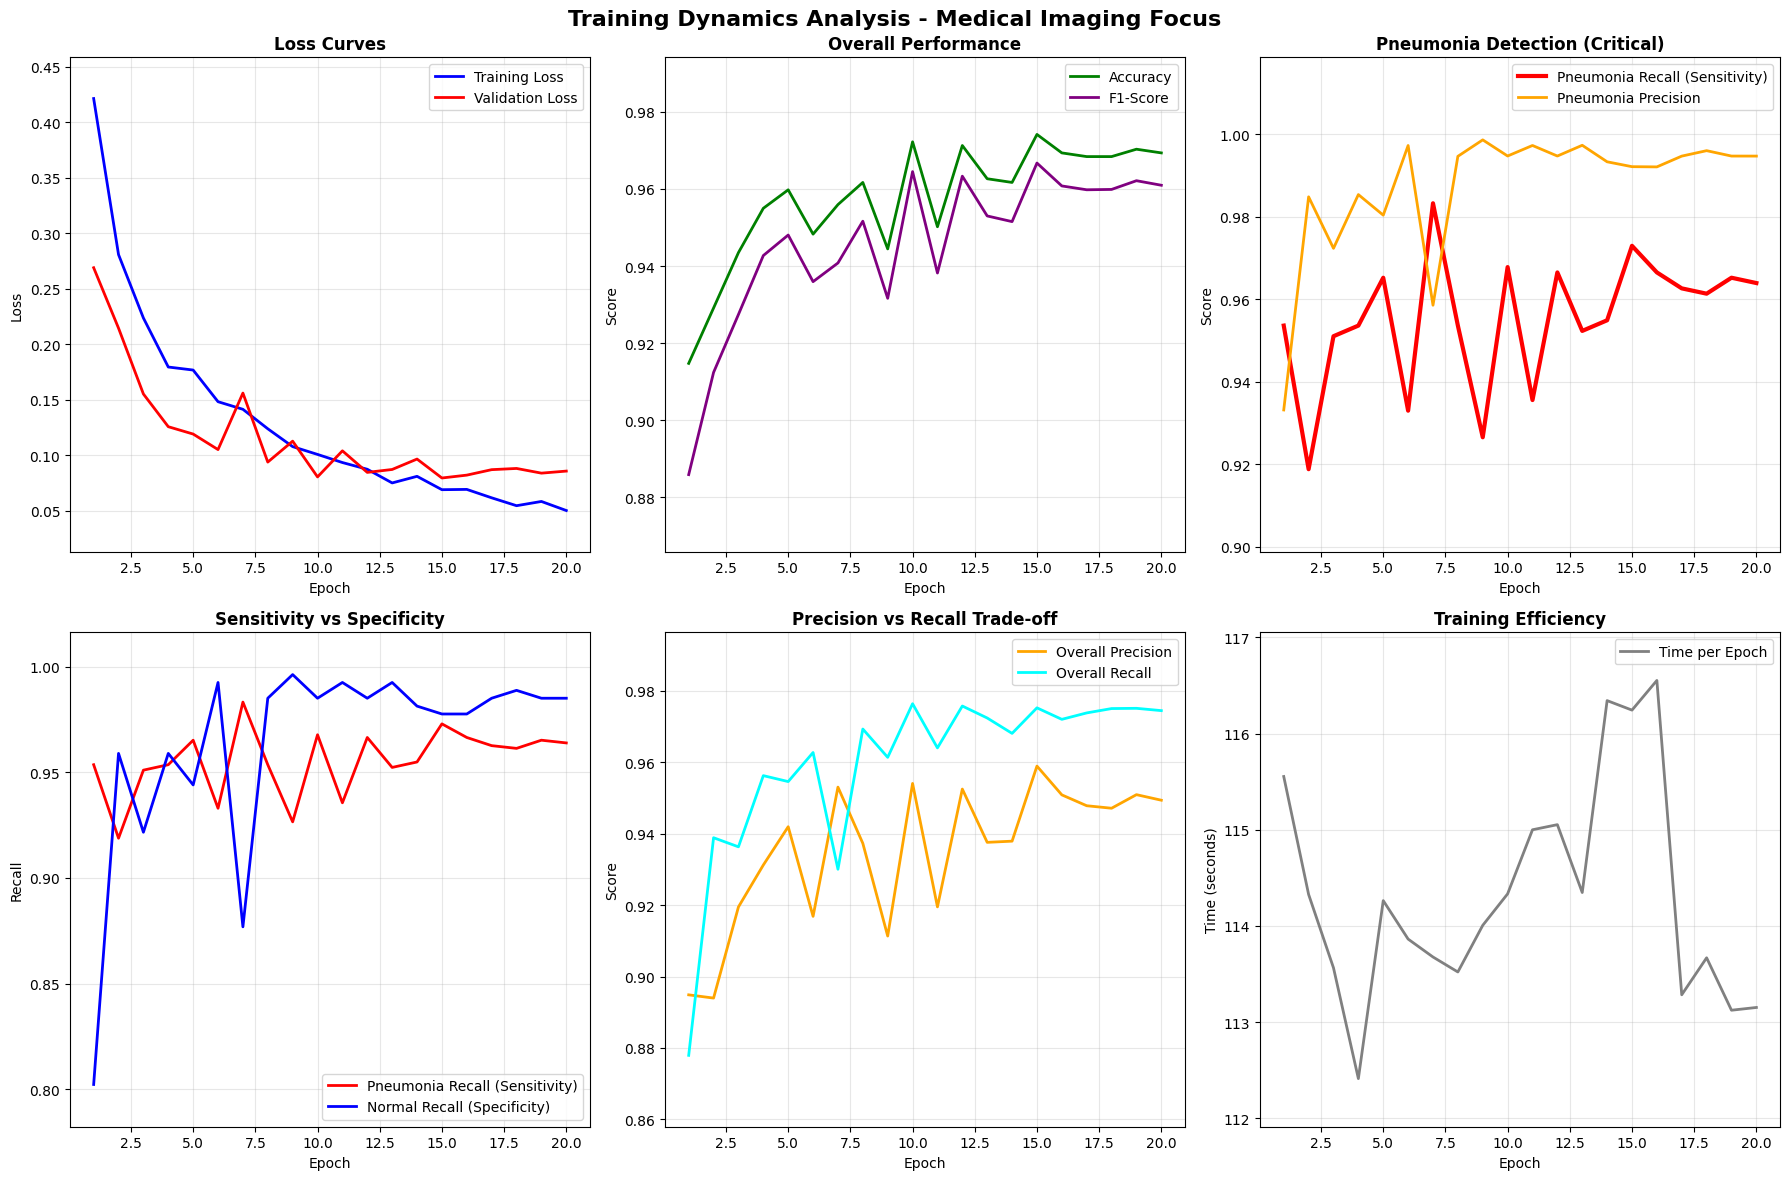

🔍 Training Dynamics Analysis
📊 Convergence Analysis:
   • Final training loss: 0.0503
   • Final validation loss: 0.0859
   • Recent training loss stability (std): 0.0065
   • Recent validation loss stability (std): 0.0022

🎯 Generalization Analysis:
   • Final train-val loss gap: 0.0355
   • Average train-val loss gap: -0.0147

⚠️  Overfitting Assessment:
   • Best validation F1: 0.9667 (epoch 15)
   • Final validation F1: 0.9610
   • F1 degradation: 0.0058

🧠 Interpretation:
   ✅ Model has converged (stable losses)
   ✅ Good generalization (small train-val gap)
   ✅ No significant overfitting

⏱️  Training Efficiency:
   • Total training time: 2315.5s
   • Average time per epoch: 115.8s
   • Parameters: 33,863,464
   • Time per parameter: 0.07ms

🏆 Architecture Search Summary:
   • Total trials: 15
⚠️  No architecture search results available. Skipping summary.


In [21]:
def plot_training_curves(history, figsize=(18, 12)):
    """Plot comprehensive training curves with medical-focused metrics."""
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle('Training Dynamics Analysis - Medical Imaging Focus', fontsize=16, fontweight='bold')
    
    # Loss curves - auto-scale for better visibility
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Loss Curves', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    # Auto-scale with small margin - start from first data point
    all_losses = history['train_loss'] + history['val_loss']
    loss_margin = (max(all_losses) - min(all_losses)) * 0.1
    axes[0, 0].set_ylim([min(all_losses) - loss_margin, max(all_losses) + loss_margin])
    
    # Overall metrics - auto-scale for better detail
    axes[0, 1].plot(epochs, history['val_accuracy'], 'g-', label='Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history['val_f1'], 'purple', label='F1-Score', linewidth=2)
    axes[0, 1].set_title('Overall Performance', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    # Auto-scale with margin - focus on actual data range
    all_scores = history['val_accuracy'] + history['val_f1']
    score_min, score_max = min(all_scores), max(all_scores)
    score_range = score_max - score_min
    score_margin = max(score_range * 0.1, 0.02)  # At least 2% margin
    axes[0, 1].set_ylim([score_min - score_margin, score_max + score_margin])
    
    # Pneumonia-specific metrics - auto-scale from first data point for better visibility
    axes[0, 2].plot(epochs, history['val_pneumonia_recall'], 'red', label='Pneumonia Recall (Sensitivity)', linewidth=3)
    axes[0, 2].plot(epochs, history['val_pneumonia_precision'], 'orange', label='Pneumonia Precision', linewidth=2)
    axes[0, 2].set_title('Pneumonia Detection (Critical)', fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    # Auto-scale from actual data range for better visibility
    pneumonia_scores = history['val_pneumonia_recall'] + history['val_pneumonia_precision']
    pn_min, pn_max = min(pneumonia_scores), max(pneumonia_scores)
    pn_range = pn_max - pn_min
    pn_margin = max(pn_range * 0.1, 0.02)  # At least 2% margin
    axes[0, 2].set_ylim([pn_min - pn_margin, pn_max + pn_margin])
    
    # Class-specific recall comparison - auto-scale from first data point
    axes[1, 0].plot(epochs, history['val_pneumonia_recall'], 'red', label='Pneumonia Recall (Sensitivity)', linewidth=2)
    axes[1, 0].plot(epochs, history['val_normal_recall'], 'blue', label='Normal Recall (Specificity)', linewidth=2)
    axes[1, 0].set_title('Sensitivity vs Specificity', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    # Auto-scale from actual data range for better visibility
    recall_scores = history['val_pneumonia_recall'] + history['val_normal_recall']
    recall_min, recall_max = min(recall_scores), max(recall_scores)
    recall_range = recall_max - recall_min
    recall_margin = max(recall_range * 0.1, 0.02)  # At least 2% margin
    axes[1, 0].set_ylim([recall_min - recall_margin, recall_max + recall_margin])
    
    # Precision vs Recall trade-off - auto-scale for better detail
    axes[1, 1].plot(epochs, history['val_precision'], 'orange', label='Overall Precision', linewidth=2)
    axes[1, 1].plot(epochs, history['val_recall'], 'cyan', label='Overall Recall', linewidth=2)
    axes[1, 1].set_title('Precision vs Recall Trade-off', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    # Auto-scale with margin - focus on actual data range
    all_pr_scores = history['val_precision'] + history['val_recall']
    pr_min, pr_max = min(all_pr_scores), max(all_pr_scores)
    pr_range = pr_max - pr_min
    pr_margin = max(pr_range * 0.1, 0.02)  # At least 2% margin
    axes[1, 1].set_ylim([pr_min - pr_margin, pr_max + pr_margin])
    
    # Training efficiency (time per epoch) - auto-scale for better visibility
    axes[1, 2].plot(epochs, history['epoch_times'], 'gray', label='Time per Epoch', linewidth=2)
    axes[1, 2].set_title('Training Efficiency', fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Time (seconds)')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    # Auto-scale with margin - focus on actual time range
    time_min, time_max = min(history['epoch_times']), max(history['epoch_times'])
    time_range = time_max - time_min
    time_margin = max(time_range * 0.1, 0.5)  # At least 0.5 second margin
    axes[1, 2].set_ylim([time_min - time_margin, time_max + time_margin])
    
    plt.tight_layout()
    plt.show()

def analyze_training_dynamics(history, model_info):
    """Analyze and interpret training dynamics."""
    
    print(f"🔍 Training Dynamics Analysis")
    print(f"="*50)
    
    train_losses = history['train_loss']
    val_losses = history['val_loss']
    val_f1_scores = history['val_f1']
    
    # Convergence analysis
    final_epochs = min(5, len(train_losses))
    recent_train_loss_std = np.std(train_losses[-final_epochs:])
    recent_val_loss_std = np.std(val_losses[-final_epochs:])
    
    print(f"📊 Convergence Analysis:")
    print(f"   • Final training loss: {train_losses[-1]:.4f}")
    print(f"   • Final validation loss: {val_losses[-1]:.4f}")
    print(f"   • Recent training loss stability (std): {recent_train_loss_std:.4f}")
    print(f"   • Recent validation loss stability (std): {recent_val_loss_std:.4f}")
    
    # Generalization gap
    final_gap = val_losses[-1] - train_losses[-1]
    avg_gap = np.mean([val_losses[i] - train_losses[i] for i in range(len(train_losses))])
    
    print(f"\n🎯 Generalization Analysis:")
    print(f"   • Final train-val loss gap: {final_gap:.4f}")
    print(f"   • Average train-val loss gap: {avg_gap:.4f}")
    
    # Overfitting assessment
    best_val_epoch = np.argmax(val_f1_scores)
    best_val_f1 = max(val_f1_scores)
    final_val_f1 = val_f1_scores[-1]
    f1_degradation = best_val_f1 - final_val_f1
    
    print(f"\n⚠️  Overfitting Assessment:")
    print(f"   • Best validation F1: {best_val_f1:.4f} (epoch {best_val_epoch + 1})")
    print(f"   • Final validation F1: {final_val_f1:.4f}")
    print(f"   • F1 degradation: {f1_degradation:.4f}")
    
    # Interpretation
    print(f"\n🧠 Interpretation:")
    
    if recent_train_loss_std < 0.01 and recent_val_loss_std < 0.01:
        print(f"   ✅ Model has converged (stable losses)")
    else:
        print(f"   ⚠️  Model may need more epochs to converge")
    
    if final_gap > 0.1:
        print(f"   ⚠️  Significant generalization gap detected")
        print(f"      → Consider regularization, dropout, or data augmentation")
    elif final_gap < 0.05:
        print(f"   ✅ Good generalization (small train-val gap)")
    else:
        print(f"   📊 Moderate generalization gap")
    
    if f1_degradation > 0.02:
        print(f"   ⚠️  Potential overfitting detected")
        print(f"      → Early stopping was beneficial")
    elif f1_degradation < 0.01:
        print(f"   ✅ No significant overfitting")
    else:
        print(f"   📊 Mild overfitting")
    
    # Training efficiency
    total_time = model_info['training_time']
    epochs_trained = model_info['epochs_trained']
    avg_epoch_time = total_time / epochs_trained
    
    print(f"\n⏱️  Training Efficiency:")
    print(f"   • Total training time: {total_time:.1f}s")
    print(f"   • Average time per epoch: {avg_epoch_time:.1f}s")
    print(f"   • Parameters: {model_info['param_count']:,}")
    print(f"   • Time per parameter: {(total_time / model_info['param_count']) * 1000:.2f}ms")

# Plot training curves
print("📈 Plotting training curves...")
plot_training_curves(training_history)

# Analyze training dynamics
analyze_training_dynamics(training_history, model_info)

try:
# Show architecture search results if available
    if search_trials > 0 and len(search_results_df) > 0:
        print(f"\n🏆 Architecture Search Summary:")
        print(f"="*50)
        print(f"   • Total trials: {len(search_results_df)}")
        print(f"   • Best F1 score: {search_results_df.iloc[0]['val_f1']:.4f}")
        print(f"   • Best configuration: {search_results_df.iloc[0]['config']}")
        
        # Show top 5 results
        print(f"\n📊 Top 5 Configurations:")
        print(f"{'Rank':<4} {'F1':<6} {'Accuracy':<8} {'Parameters':<10} {'Config Summary'}")
        print(f"{'-'*70}")
        
        for i in range(min(5, len(search_results_df))):
            row = search_results_df.iloc[i]
            config_summary = f"d{row['config']['depth']}_c{row['config']['base_channels']}_" + \
                            f"{row['config']['activation'][:4]}_bn{int(row['config']['use_bn'])}"
            print(f"{i+1:<4} {row['val_f1']:.3f}  {row['val_accuracy']:.3f}    "
                f"{row['param_count']:<10,} {config_summary}")

    print(f"\n✅ Training analysis complete!")
except:
    print(f"⚠️  No architecture search results available. Skipping summary.")    

## 🎯 Final Test Evaluation

🎯 FINAL TEST EVALUATION

📥 Loading best model from: final_models/best_model_2025-08-09 00:23.pt
✅ Model loaded successfully
   • Parameters: 33,863,464
   • Device: mps

🔍 Evaluating on test set...


Evaluating: 100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


🎉 TEST EVALUATION COMPLETED!
   • Evaluation time: 25.0s
   • Test samples: 624

📊 Final Test Performance
🎯 Overall Performance:
   • Accuracy:        0.8253
   • Precision (macro): 0.8671
   • Recall (macro):    0.7739
   • F1-Score (macro):  0.7922

🏷️  Per-Class Performance:
   NORMAL:
     - Precision: 0.9433
     - Recall:    0.5684
     - F1-Score:  0.7093
   PNEUMONIA:
     - Precision: 0.7909
     - Recall:    0.9795
     - F1-Score:  0.8751

⚖️  Weighted Averages:
   • Precision: 0.8480
   • Recall:    0.8253
   • F1-Score:  0.8130

📊 Test Set Confusion Matrix:


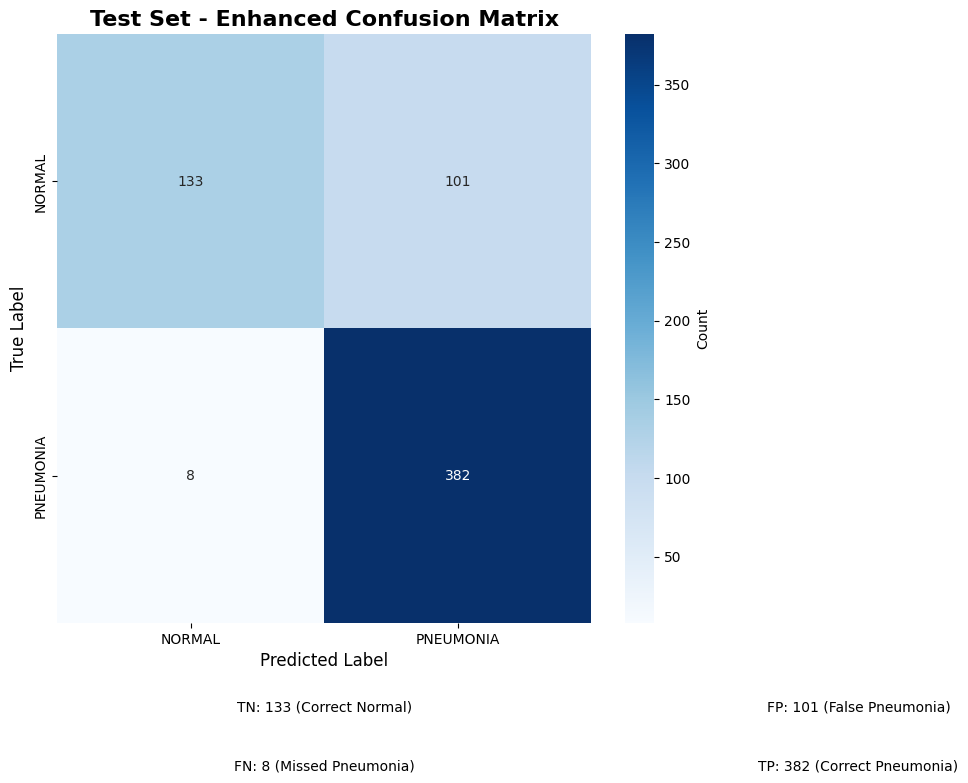


📈 ROC Curve Analysis:


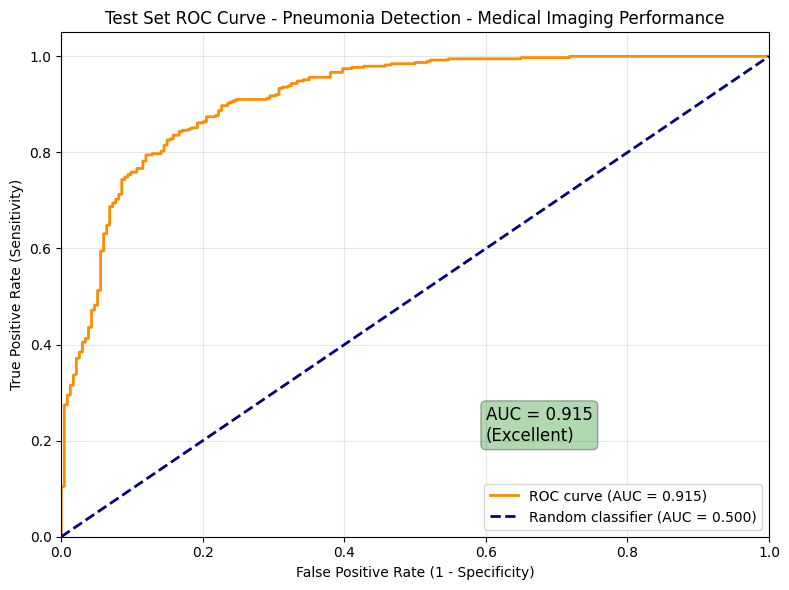

🎯 ROC-AUC Analysis:
   • AUC Score: 0.9148
   • Interpretation: Excellent
   • Clinical Context:
     → Excellent discriminatory ability
     → Model can effectively distinguish pneumonia from normal cases

📈 Precision-Recall Curve Analysis:


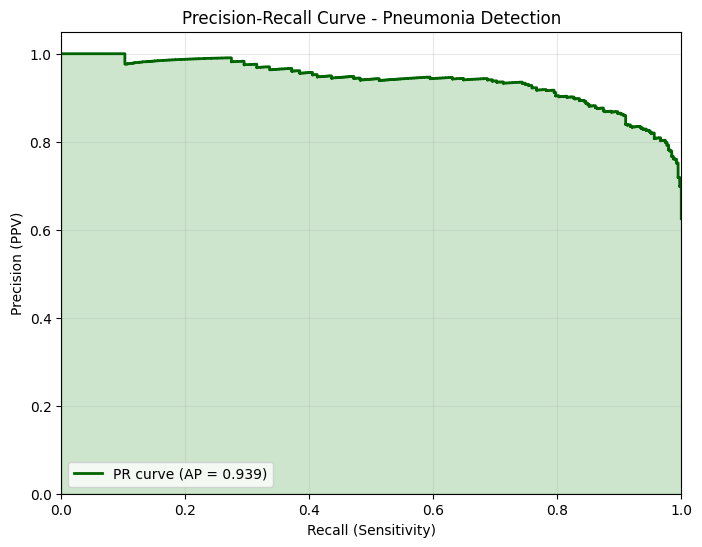

🎯 Precision-Recall Analysis:
   • Average Precision (AP) Score: 0.9394

📋 Detailed Classification Report:
              precision  recall  f1-score   support
NORMAL           0.9433  0.5684    0.7093  234.0000
PNEUMONIA        0.7909  0.9795    0.8751  390.0000
accuracy         0.8253  0.8253    0.8253    0.8253
macro avg        0.8671  0.7739    0.7922  624.0000
weighted avg     0.8480  0.8253    0.8130  624.0000

🔄 Validation vs Test Performance Comparison:
Metric               Validation   Test         Difference  
------------------------------------------------------------
accuracy             0.9693       0.8253       -0.1440     
precision_macro      0.9494       0.8671       -0.0823     
recall_macro         0.9745       0.7739       -0.2006     
f1_macro             0.9610       0.7922       -0.1687     

📈 Generalization Assessment:
   • Validation F1: 0.9610
   • Test F1: 0.7922
   • Absolute difference: 0.1687
   🚨 Significant generalization gap - possible overfitting

📊 FI

In [22]:
print("🎯 FINAL TEST EVALUATION")

# Load the best model
print(f"\n📥 Loading best model from: {save_path}")
# Why again 
test_model = create_model_from_config(best_config, input_channels=3)
test_model.load_state_dict(torch.load(save_path, map_location=device))
test_model = test_model.to(device)

print(f"✅ Model loaded successfully")
print(f"   • Parameters: {test_model.get_param_count():,}")
print(f"   • Device: {device}")

# Evaluate on test set
print(f"\n🔍 Evaluating on test set...")
test_start_time = time.time()

test_labels, test_preds, test_scores, test_metrics = evaluate_model(
    test_model, final_test_loader, device, class_names=['NORMAL', 'PNEUMONIA']
)

test_eval_time = time.time() - test_start_time

# Print comprehensive test results
print(f"\n🎉 TEST EVALUATION COMPLETED!")
print(f"   • Evaluation time: {test_eval_time:.1f}s")
print(f"   • Test samples: {len(test_labels):,}")

# Detailed metrics summary
print_metrics_summary(test_metrics, "Final Test Performance")

# Plot confusion matrix
print(f"\n📊 Test Set Confusion Matrix:")
test_cm_raw, test_cm_norm = plot_confusion_matrix(
    test_labels, test_preds, 
    class_names=['NORMAL', 'PNEUMONIA'],
    title_prefix="Test Set - "
)

# Plot ROC curve
print(f"\n📈 ROC Curve Analysis:")
test_roc_auc = plot_roc_curve(
    test_labels, test_scores, 
    title="Test Set ROC Curve - Pneumonia Detection"
)


# Plot Precision-Recall curve
print(f"\n📈 Precision-Recall Curve Analysis:")
test_pr_auc = plot_precision_recall_curve(
    test_labels, test_scores,
    title="Precision-Recall Curve - Pneumonia Detection"
)

# Classification report as DataFrame
test_report_df = classification_report_to_df(
    test_labels, test_preds, 
    class_names=['NORMAL', 'PNEUMONIA']
)

print(f"\n📋 Detailed Classification Report:")
print(test_report_df.round(4))

# Compare with validation performance
print(f"\n🔄 Validation vs Test Performance Comparison:")
print(f"{'Metric':<20} {'Validation':<12} {'Test':<12} {'Difference':<12}")
print(f"{'-'*60}")

comparison_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
for metric in comparison_metrics:
    val_score = final_metrics[metric]
    test_score = test_metrics[metric]
    diff = test_score - val_score
    
    print(f"{metric:<20} {val_score:<12.4f} {test_score:<12.4f} {diff:<+12.4f}")

# Generalization assessment
val_test_gap = abs(test_metrics['f1_macro'] - final_metrics['f1_macro'])
print(f"\n📈 Generalization Assessment:")
print(f"   • Validation F1: {final_metrics['f1_macro']:.4f}")
print(f"   • Test F1: {test_metrics['f1_macro']:.4f}")
print(f"   • Absolute difference: {val_test_gap:.4f}")

if val_test_gap < 0.02:
    print(f"   ✅ Excellent generalization (difference < 0.02)")
elif val_test_gap < 0.05:
    print(f"   📊 Good generalization (difference < 0.05)")
elif val_test_gap < 0.1:
    print(f"   ⚠️  Moderate generalization gap")
else:
    print(f"   🚨 Significant generalization gap - possible overfitting")

# Final test summary with timestamp
test_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print(f"\n" + "="*60)
print(f"📊 FINAL TEST SUMMARY")
print(f"="*60)
print(f"   • Timestamp: {test_timestamp}")
print(f"   • Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"   • Test Precision (macro): {test_metrics['precision_macro']:.4f}")
print(f"   • Test Recall (macro): {test_metrics['recall_macro']:.4f}")
print(f"   • Test F1-Score (macro): {test_metrics['f1_macro']:.4f}")
print(f"   • Test ROC-AUC: {test_roc_auc:.4f}")
print(f"   • Model Parameters: {test_model.get_param_count():,}")
print(f"   • Training Time: {model_info['training_time']:.1f}s")
print(f"   • Architecture Search: {'Yes' if search_trials > 0 else 'No'}")
print(f"="*60)

# Store test results for later reference
test_results = {
    'timestamp': test_timestamp,
    'metrics': test_metrics,
    'confusion_matrix': test_cm_raw,
    'confusion_matrix_normalized': test_cm_norm,
    'classification_report': test_report_df,
    'test_labels': test_labels,
    'test_predictions': test_preds,
    'test_scores': test_scores,  # Added: Raw prediction scores for ROC analysis
    'roc_auc': test_roc_auc,    # Added: ROC AUC score
    'evaluation_time': test_eval_time,
    'val_test_comparison': {
        'val_f1': final_metrics['f1_macro'],
        'test_f1': test_metrics['f1_macro'],
        'generalization_gap': val_test_gap
    }
}

print(f"\n✅ Test evaluation complete and results saved!")
print(f"   🔒 Test set is now locked for this session.")
print(f"   📊 Use these results for final model assessment and reporting.")